# DESI PV Y1 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **9 August 2024**

**Note:** This requires using a subclassed version of `hyperfit`.

Potential updates to this notebook:
* ~~Improved identification of spiral galaxy morphologies in the SGA (currently using LEDA morphological classification).~~
* Larger statistics of SN Ia calibrators with rotation curve measurements and independent distance moduli.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

<Table length=5>
SGA_ID  SGA_GALAXY  ...      V_0p4R26         V_0p4R26_err  
int64    bytes16    ...      float64            float64     
------ ------------ ... ------------------ -----------------
    38  SGA-2020 38 ... 132.22926444835167 2.692954944764243
    55  SGA-2020 55 ...  81.16476690678293 3.206028942306434
   117 SGA-2020 117 ...  196.9219365823643 8.872544171017122
   223 SGA-2020 223 ...   72.4872885447414 4.398954989347998
   581 SGA-2020 581 ...  139.5737119504785 4.578189350223568

# Load Morphological Classification using the Random Forest & SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on a random forest (J. Largett, University of Rochester, in preparation) and the SSL sorter (using a nearest-neighbor query). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [4]:
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

<Table length=5>
 SGA_ID Predicted_Type_RF ... Predicted_Type_EvenTraining_knn
float64       str10       ...              str10             
------- ----------------- ... -------------------------------
   38.0           Unknown ...                      Lenticular
   55.0           Unknown ...                       Irregular
  117.0           Unknown ...                      Lenticular
  223.0           Unknown ...                       Irregular
  581.0            Spiral ...                       Irregular

In [5]:
#- Create an overall record of the RF prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

#- Select records where the 2 of 3 RF selections agree.
rf_classes = ['Elliptical', 'Irregular', 'Lenticular', 'Spiral']
for rf_class in rf_classes:
    is_class = ((ai_morphtab['Predicted_Type_RF']==rf_class) & (ai_morphtab['Predicted_Type_UnevenTraining_knn']==rf_class)) | \
               ((ai_morphtab['Predicted_Type_RF']==rf_class) & (ai_morphtab['Predicted_Type_EvenTraining_knn']==rf_class)) | \
               ((ai_morphtab['Predicted_Type_UnevenTraining_knn']==rf_class) & (ai_morphtab['Predicted_Type_EvenTraining_knn']==rf_class))

    ai_morphtab['Predicted_Type'][is_class] = rf_class

ai_morphtab[:5]

<Table length=5>
 SGA_ID Predicted_Type_RF ... Predicted_Type_EvenTraining_knn Predicted_Type
float64       str10       ...              str10                  str10     
------- ----------------- ... ------------------------------- --------------
   38.0           Unknown ...                      Lenticular     Undecided 
   55.0           Unknown ...                       Irregular     Undecided 
  117.0           Unknown ...                      Lenticular     Undecided 
  223.0           Unknown ...                       Irregular     Undecided 
  581.0            Spiral ...                       Irregular         Spiral

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query) (J. Largett, University of Rochester, in preparation). The classification ignored the Hubble sub-types and classified the galaxies as either spiral or other.

Let's also load this table and add it to the SGA table.

In [4]:
ai_morphpath = '/pscratch/sd/j/jlargett/DESI_SGA_MINE/Sorter/binary_results'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphcsv = os.path.join(ai_morphpath, 'model_predictions_10278.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

PermissionError: [Errno 13] Permission denied: '/pscratch/sd/j/jlargett/DESI_SGA_MINE/Sorter/binary_results/model_predictions_10278.csv'

# Combine ML morphtypes with SGA catalog

In [6]:
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [7]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph

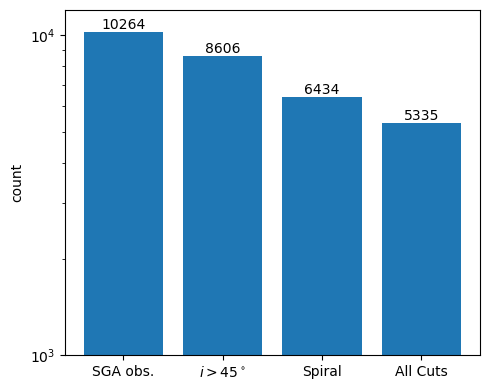

In [8]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    'Spiral' : np.sum(is_good_morph),
    'All Cuts' : np.sum(is_good_sga)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count', yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150);

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [9]:
zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [10]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
# zeroptab.write('SGA_distances_0pt_iron.fits', overwrite=True)
zeroptab[:5]

<Table length=5>
SGA_ID    SGA_GALAXY            GALAXY         ...  MU_ERR  MU_SOURCE
int64      bytes16             bytes29         ... float64   bytes22 
------ --------------- ----------------------- ... -------- ---------
109750 SGA-2020 109750               PGC007299 ... 0.173532    2005hc
119118 SGA-2020 119118              PGC1310038 ... 0.340606    2007ba
122260 SGA-2020 122260 SDSSJ130323.44+271825.0 ...  0.21848    2010ai
124900 SGA-2020 124900              PGC1111212 ... 0.149593   PS16ayd
183909 SGA-2020 183909               PGC048632 ...   0.2098    2010ao

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

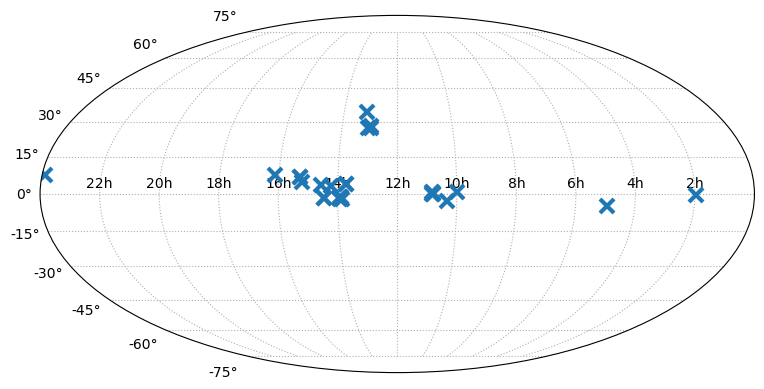

In [11]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [12]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR']**2 + zeroptab['MU_ERR']**2)

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [13]:
clusters = Table.read('../Tully15-Table3.fits')
clusters[:5]

<Table length=5>
f_Nest  Nest   Nmb    PGC1   SGLON   ...  sigV    R2t    sigP     Mlum      CF  
                              deg    ... km / s   Mpc   km / s    Msun          
int16  int32  int16  int32  float64  ... int16  float64 int16   float64  float64
------ ------ ----- ------- -------- ... ------ ------- ------ --------- -------
     1 100001   136   44715  89.6226 ...    886   2.129   1045 1.710e+15    1.65
     1 100002   197   41220 103.0008 ...    670   1.440    707 5.290e+14    1.00
     1 100003   113   43296 156.2336 ...    822   1.520    746 6.230e+14    1.12
     1 100004    81   58265  71.5103 ...    740   2.153   1057 1.770e+15    2.26
     1 100005    61   36487  92.0255 ...    707   1.560    766 6.730e+14    1.58

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [14]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

In [15]:
sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 15

# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    nest_id = clusters['Nest'][i]
    
    #- Sky coordinates of cluster
    cls_coord = SkyCoord(clusters['SGLON'][i], 
                         clusters['SGLAT'][i], 
                         unit='deg', 
                         frame='supergalactic')

    #- Cluster turnaround radius, velocity dispersion, and distance modulus
    R2t = clusters['R2t'][i]
    sigP = clusters['sigP'][i]
    mu = clusters['DM'][i]

    #- Convert distance moduli to velocities [in km/s]
    dist = 10 * 10**(0.2*mu)
    velo = 100 * (dist*1e-6) # Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
        m_dwarf_clusters[nest_id] = -17 + mu

100%|██████████| 25474/25474 [02:51<00:00, 148.90it/s]


In [16]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100002  30 galaxies
 2  100007  20 galaxies
 3  100042  19 galaxies
 4  100046  17 galaxies
 5  100058  25 galaxies
 6  100067  32 galaxies
 7  100077  15 galaxies
 8  100081  17 galaxies
 9  100094  15 galaxies
10  100282  25 galaxies
11  101400  27 galaxies
12  101434  18 galaxies
13  101788  24 galaxies
14  101823  15 galaxies
15  102885  17 galaxies
16  103172  17 galaxies
17  103175  18 galaxies
18  103182  27 galaxies
19  103203  23 galaxies
20  103229  19 galaxies
21  103332  15 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

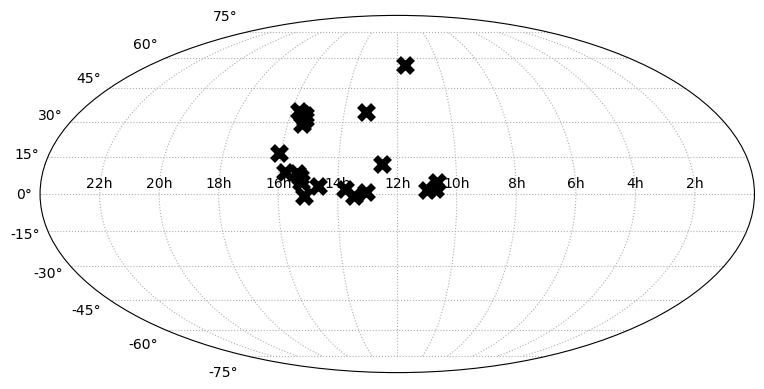

In [16]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters.png', dpi=150);

In [17]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [19]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 545 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 781 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (197.68010565, 34.27637749)>
11168.632477805635 +/- 635 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (229.29825678, 7.14058993)>
10914.403364487573 +/- 653 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<Sky

/tmp/ipykernel_577397/1761111452.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


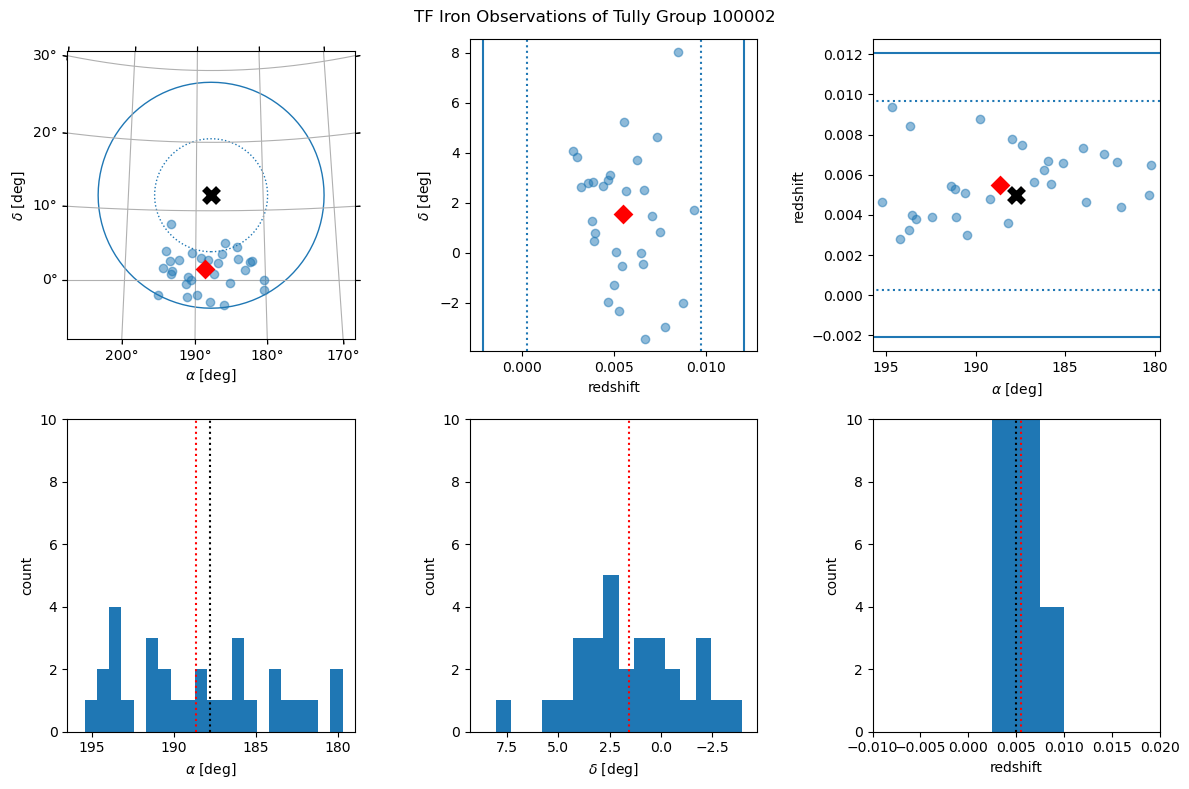

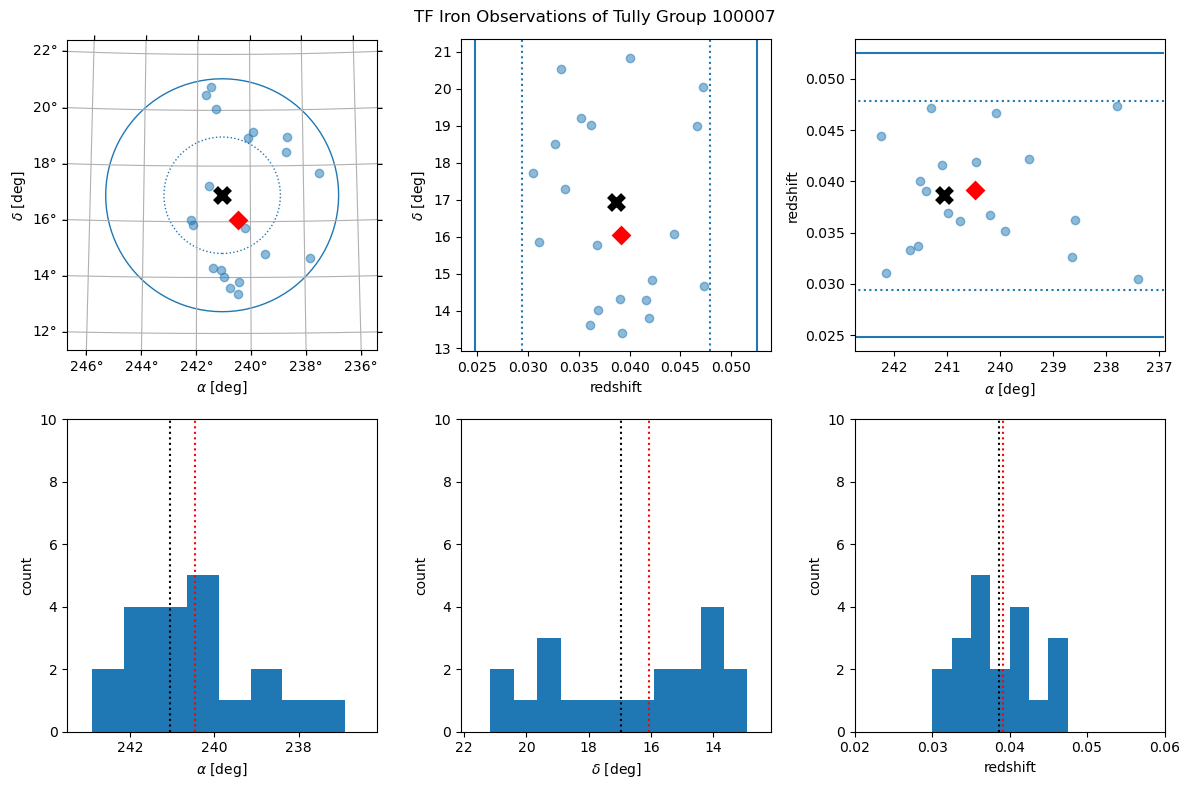

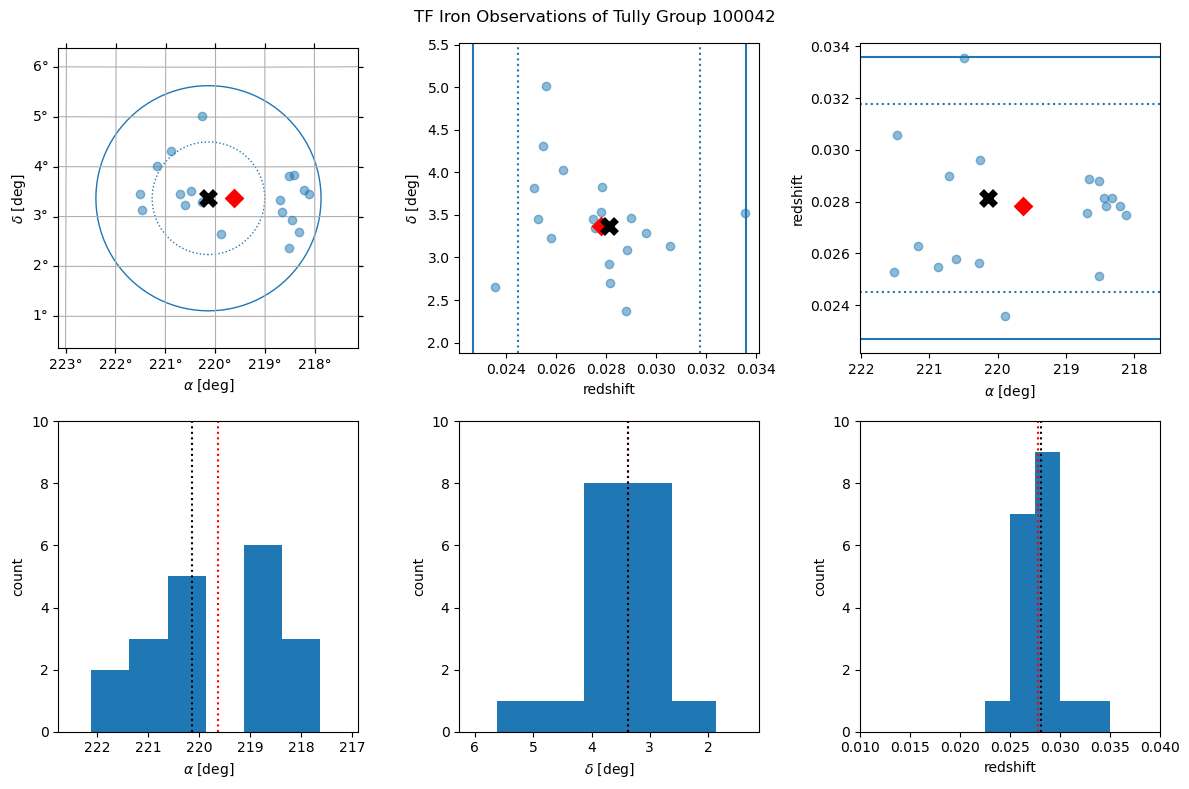

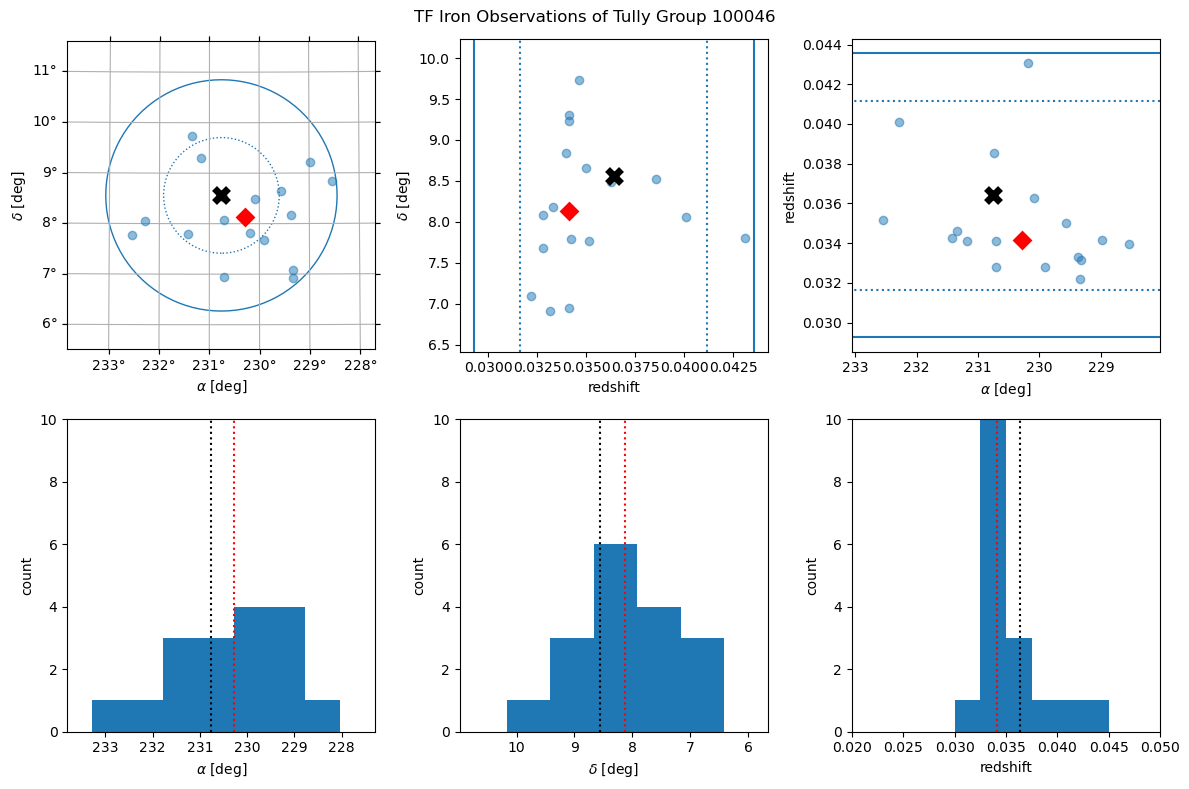

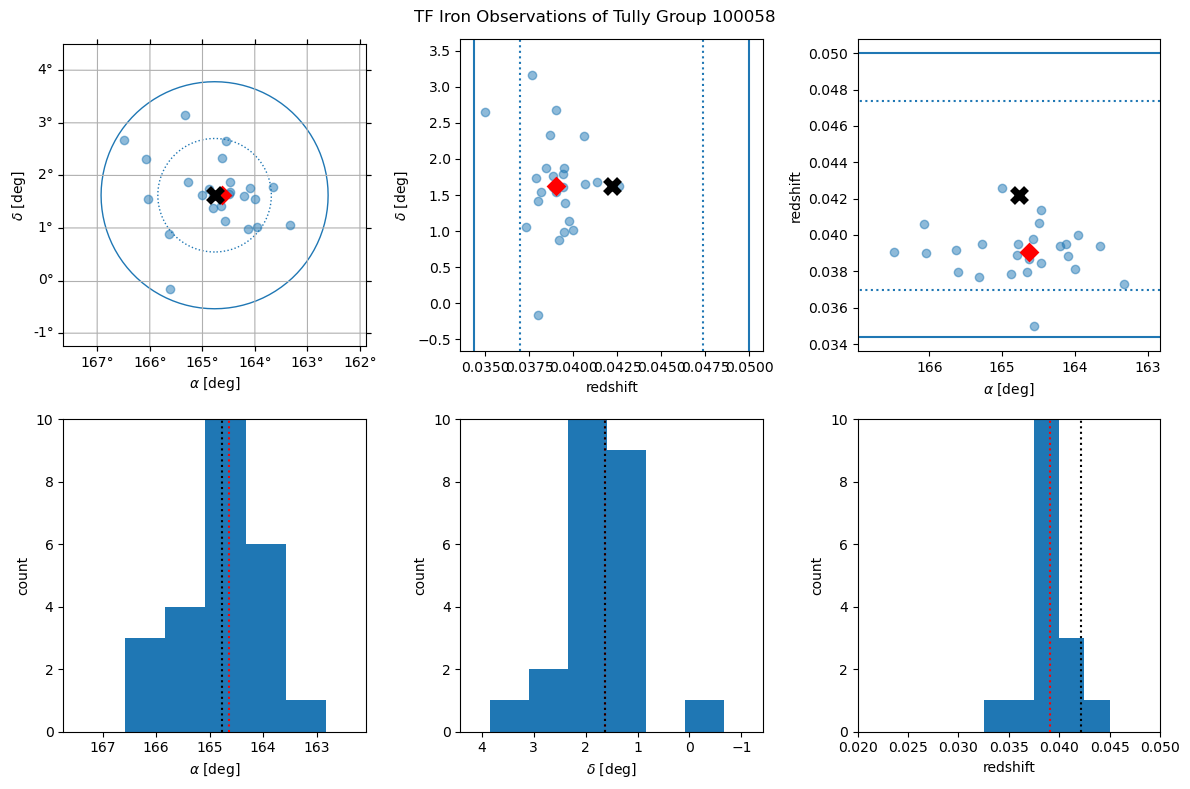

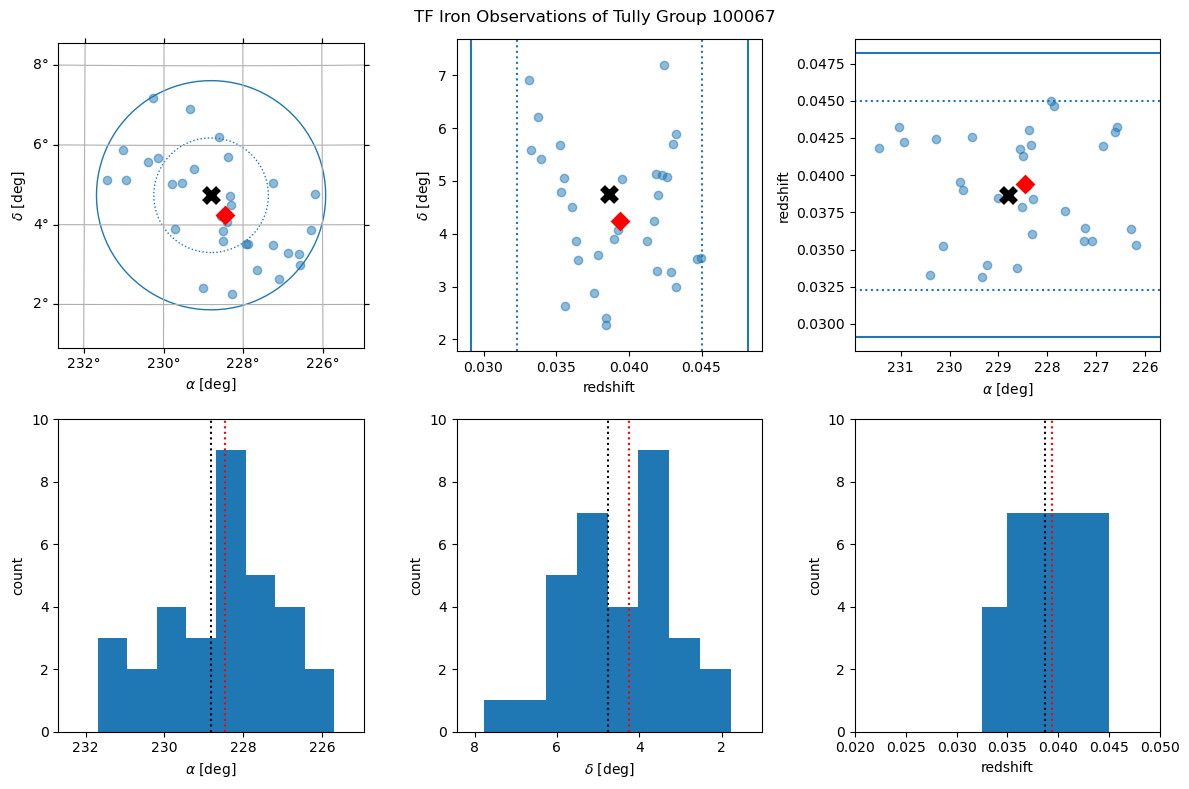

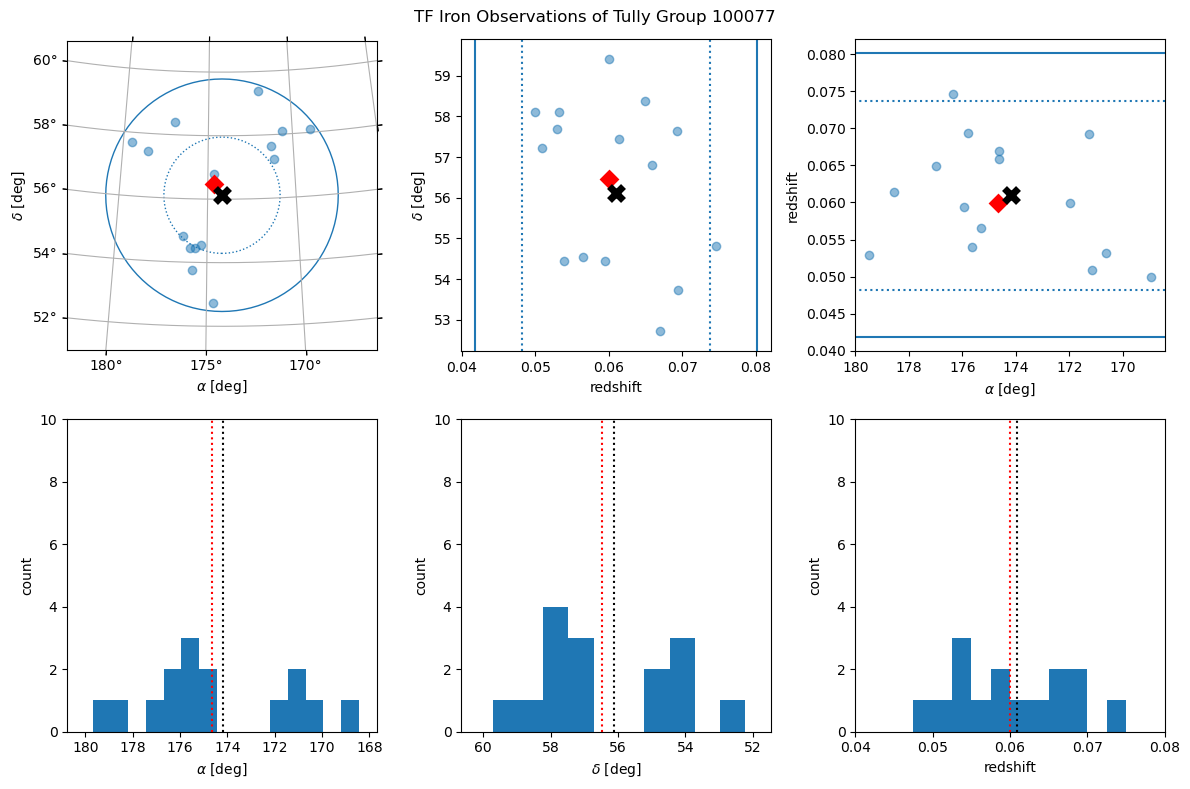

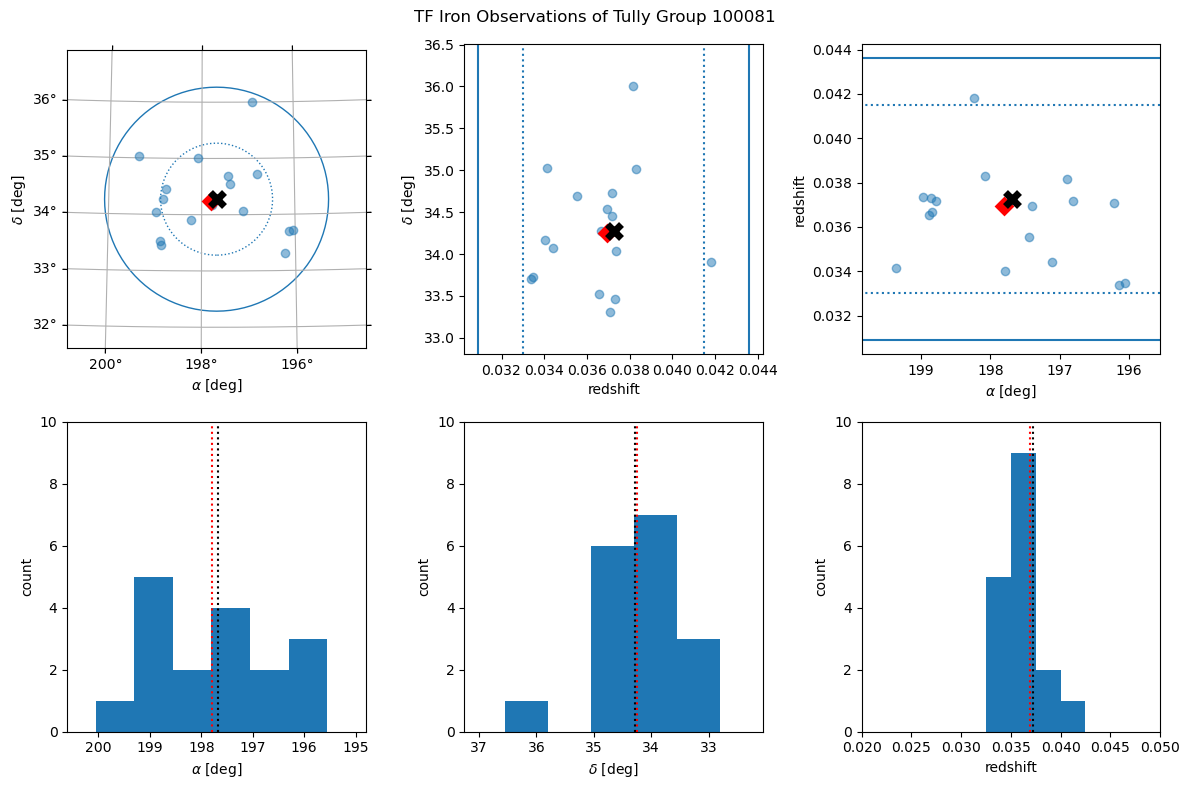

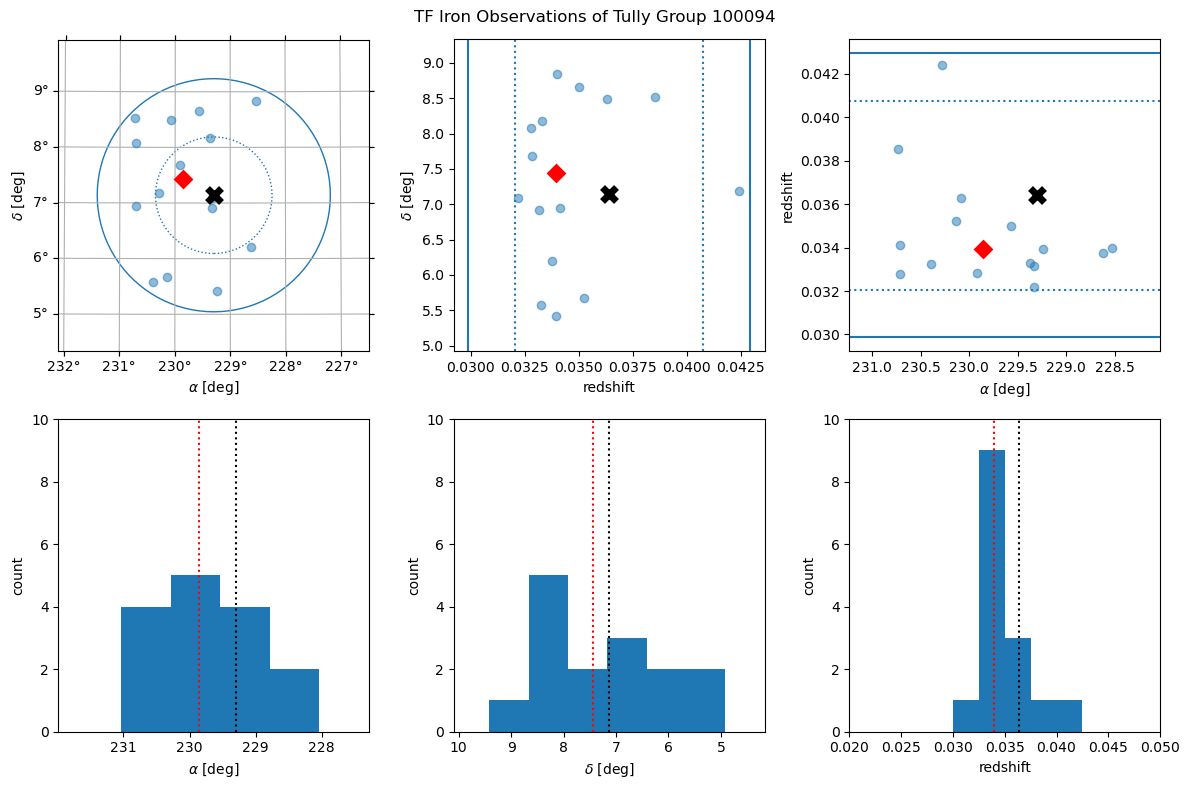

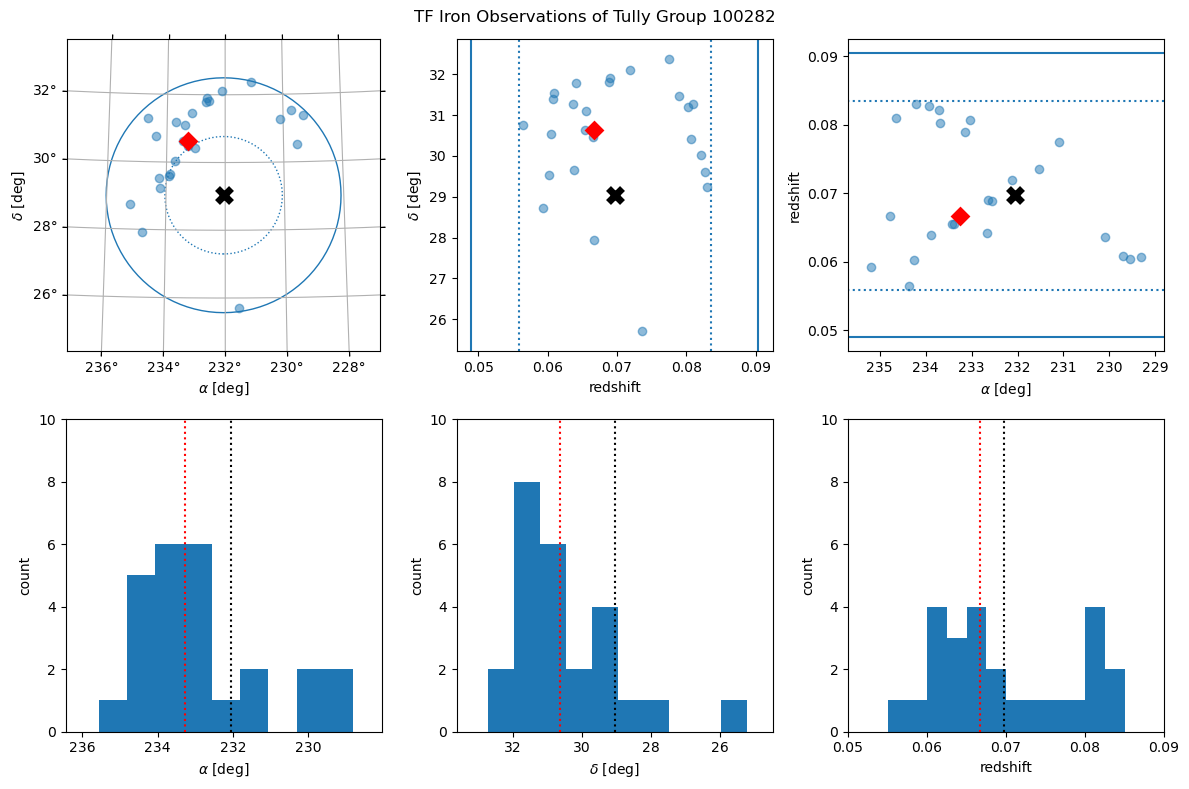

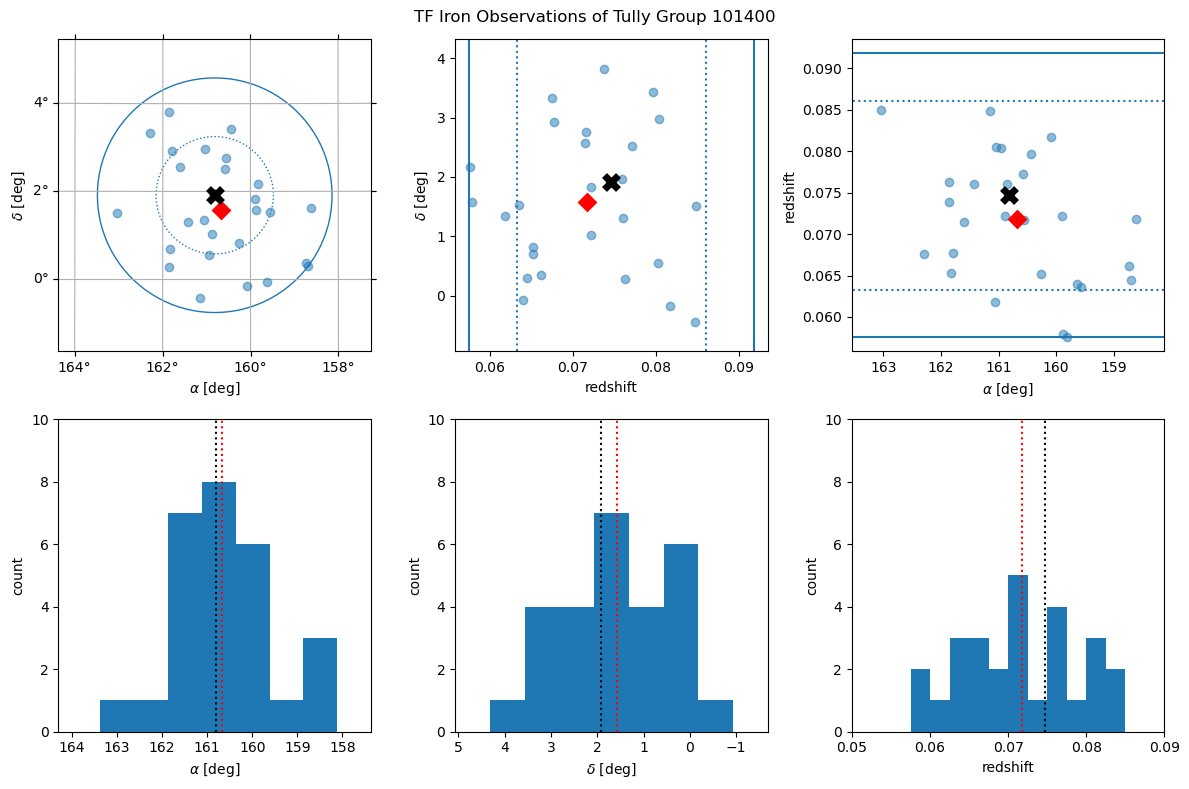

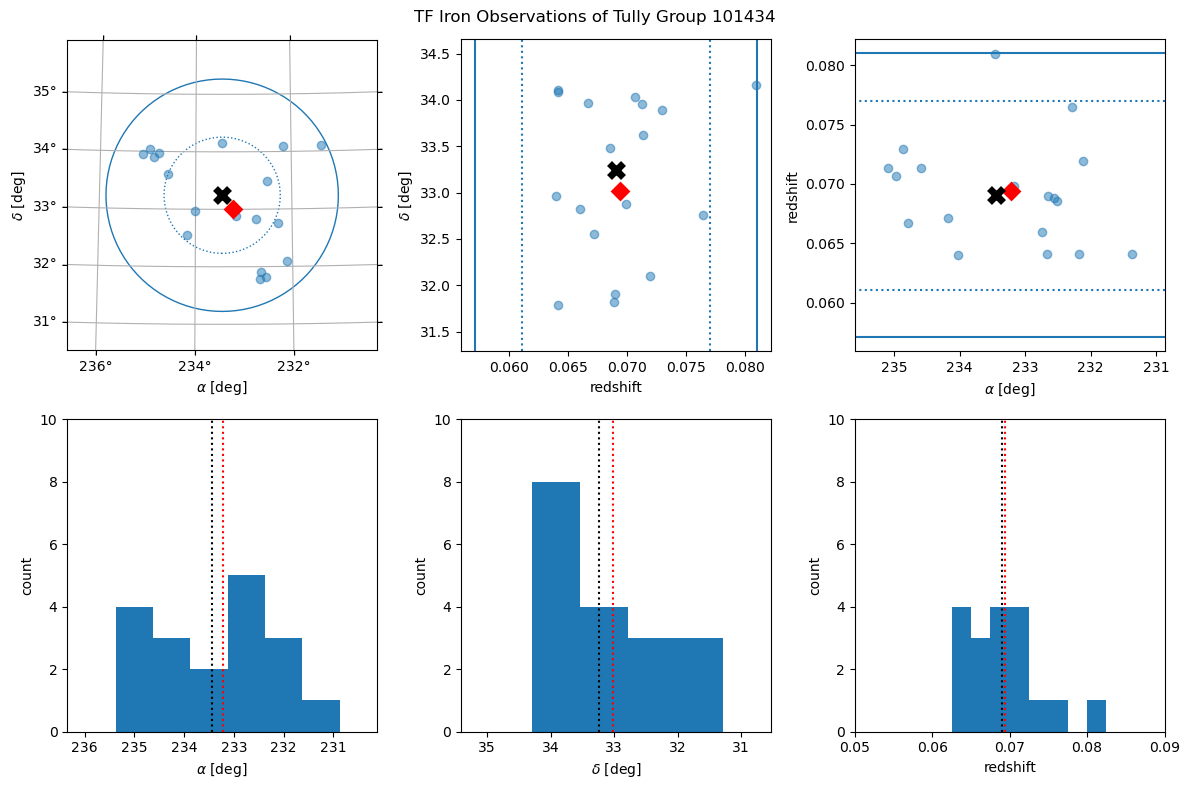

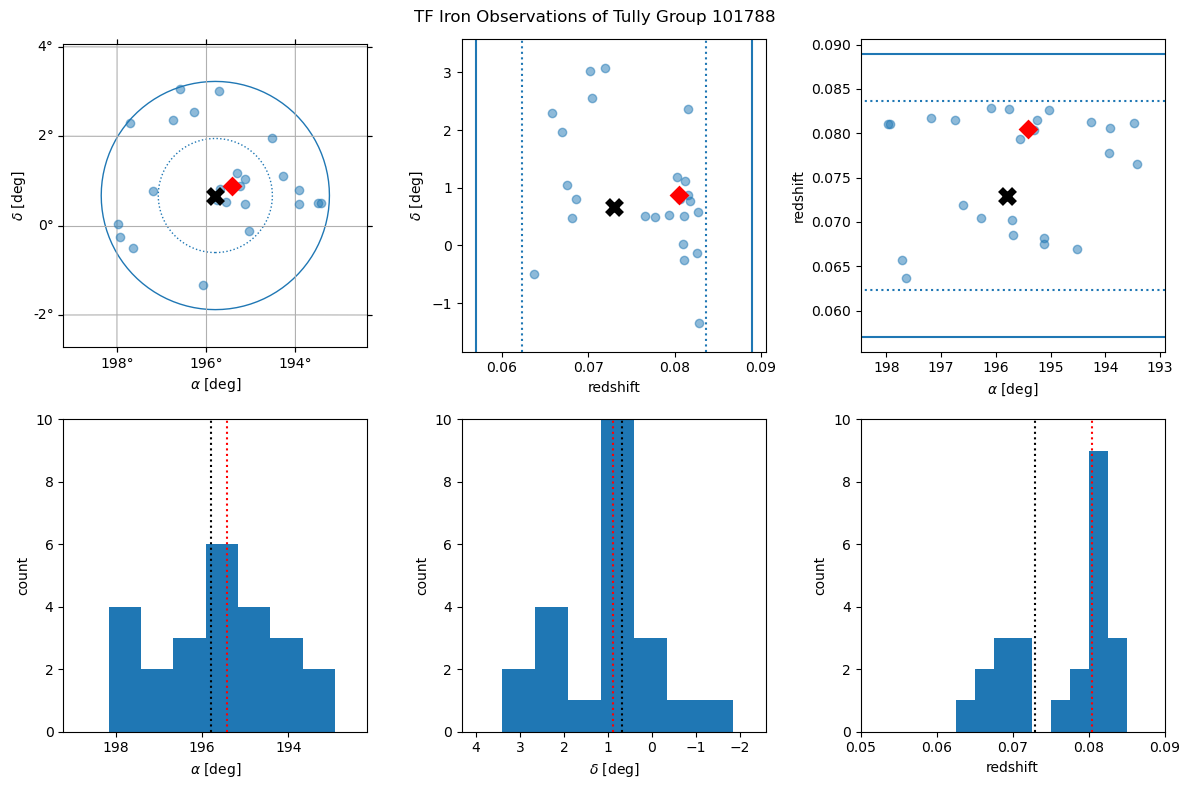

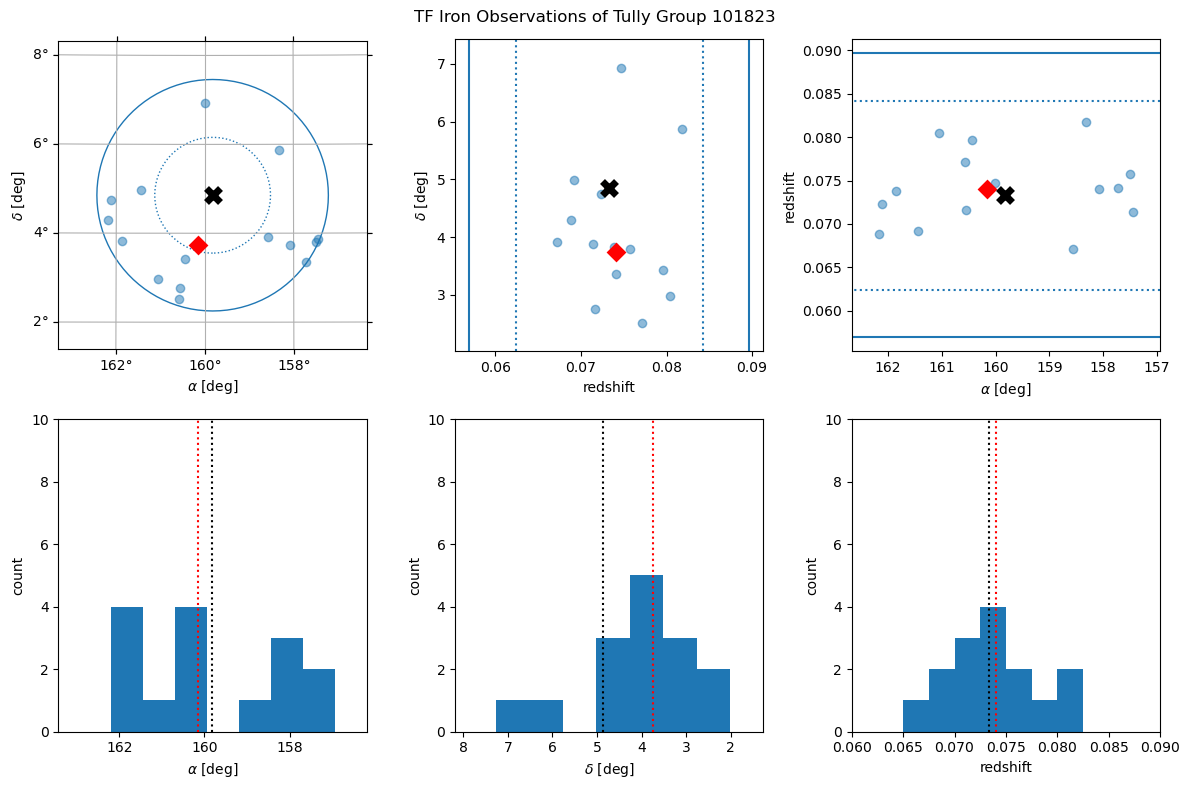

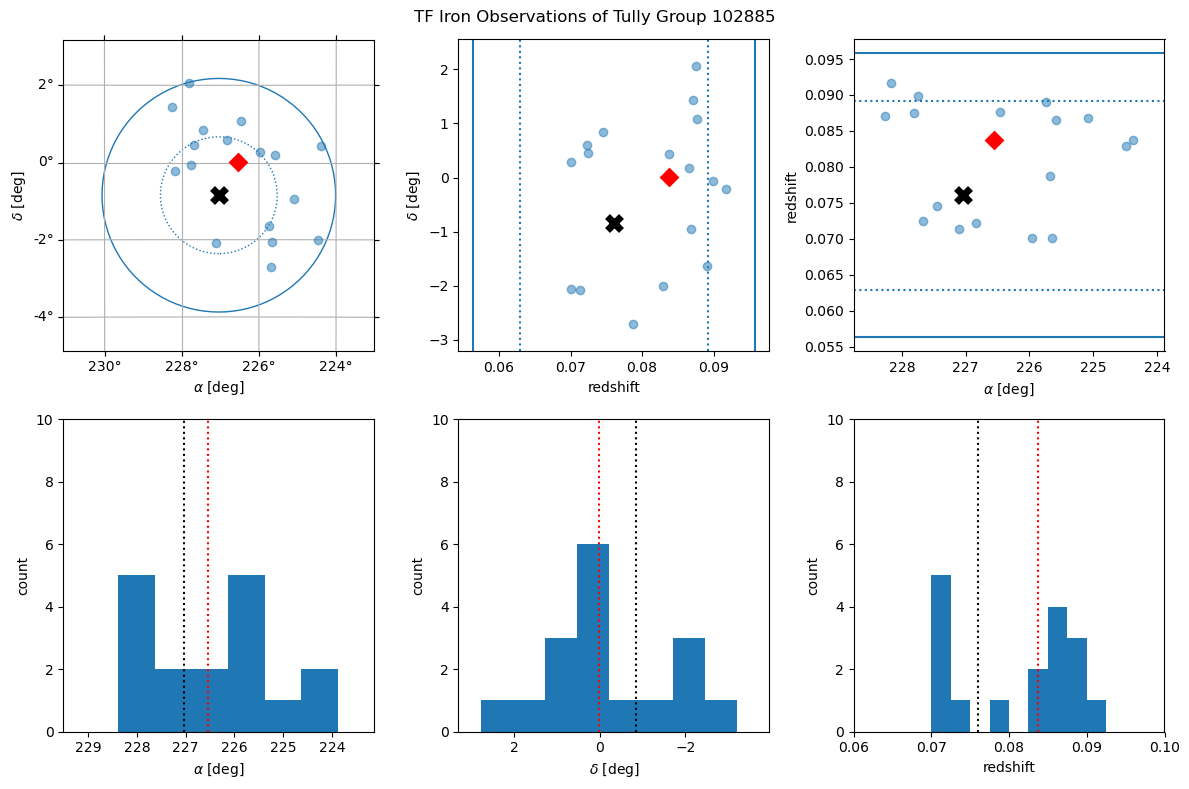

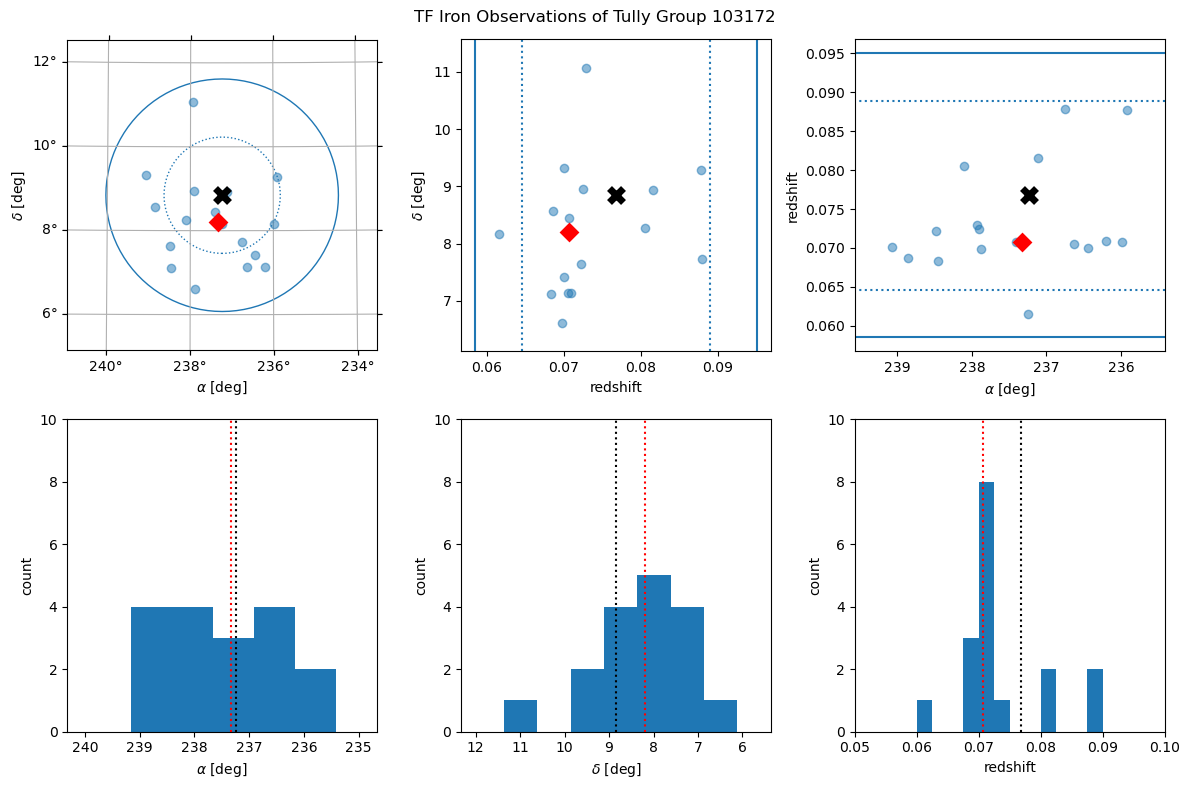

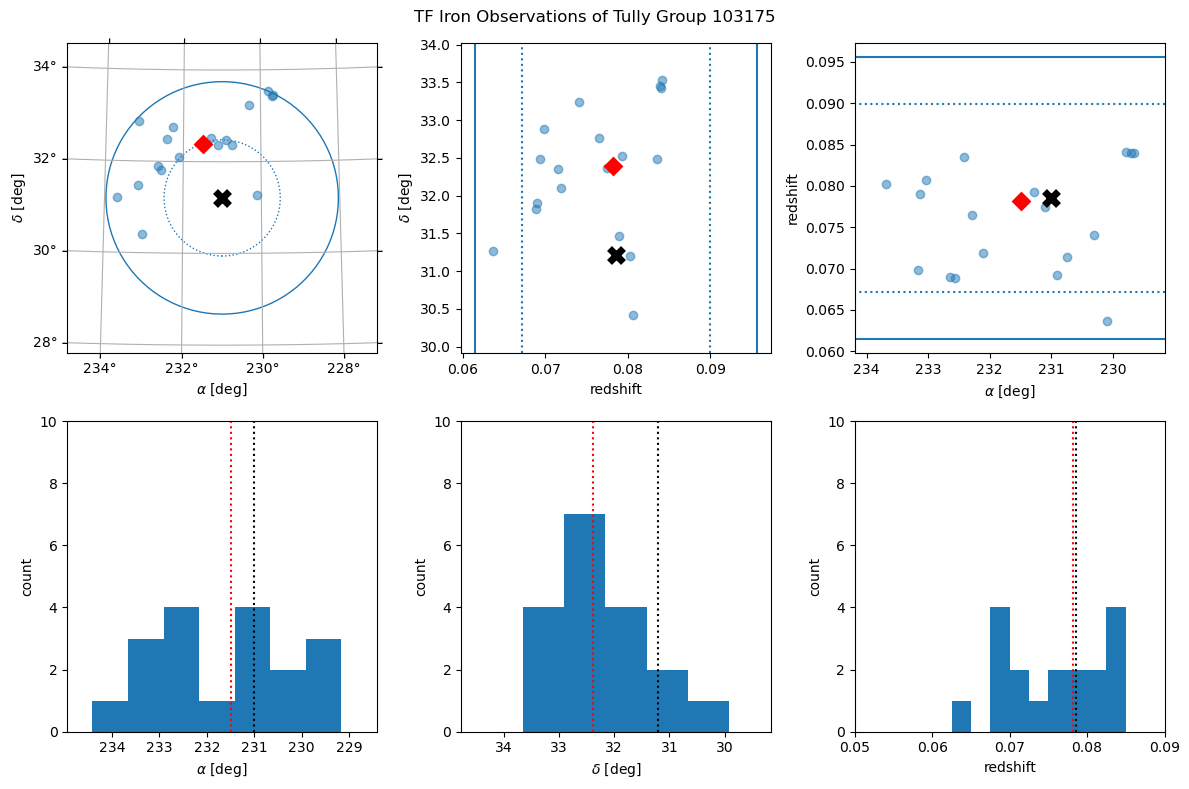

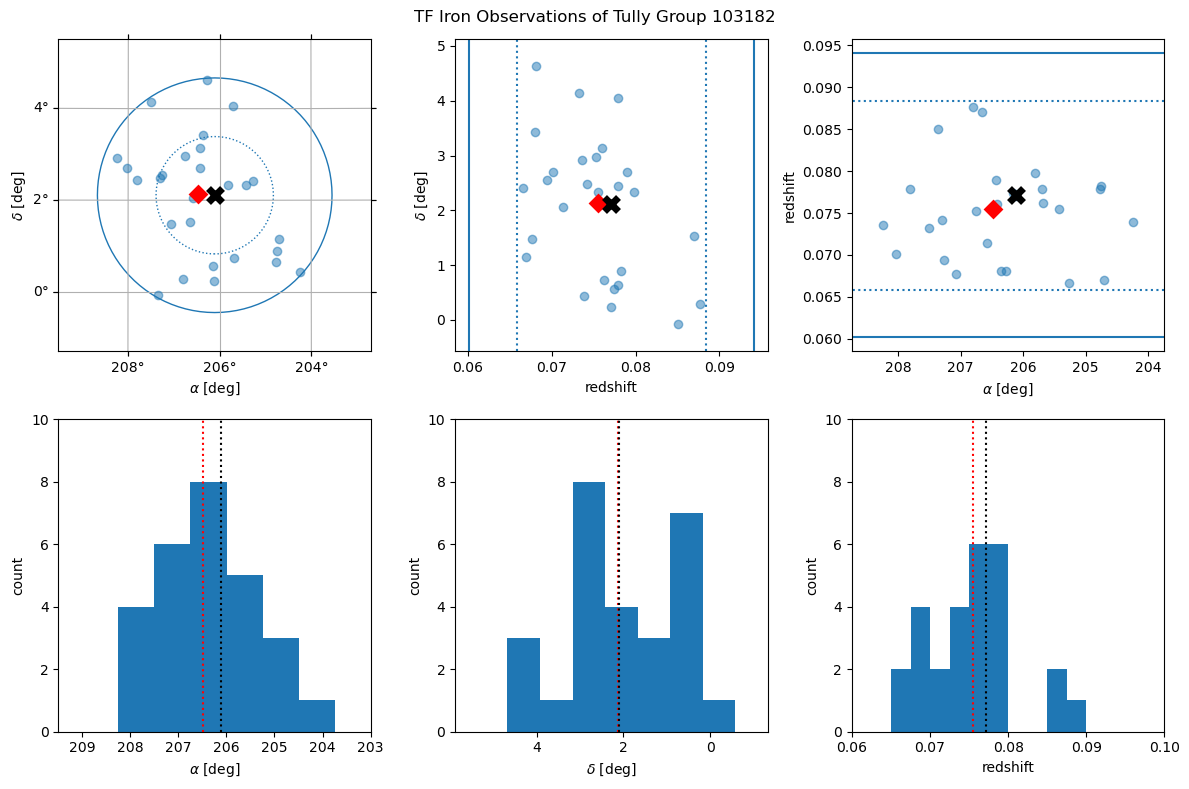

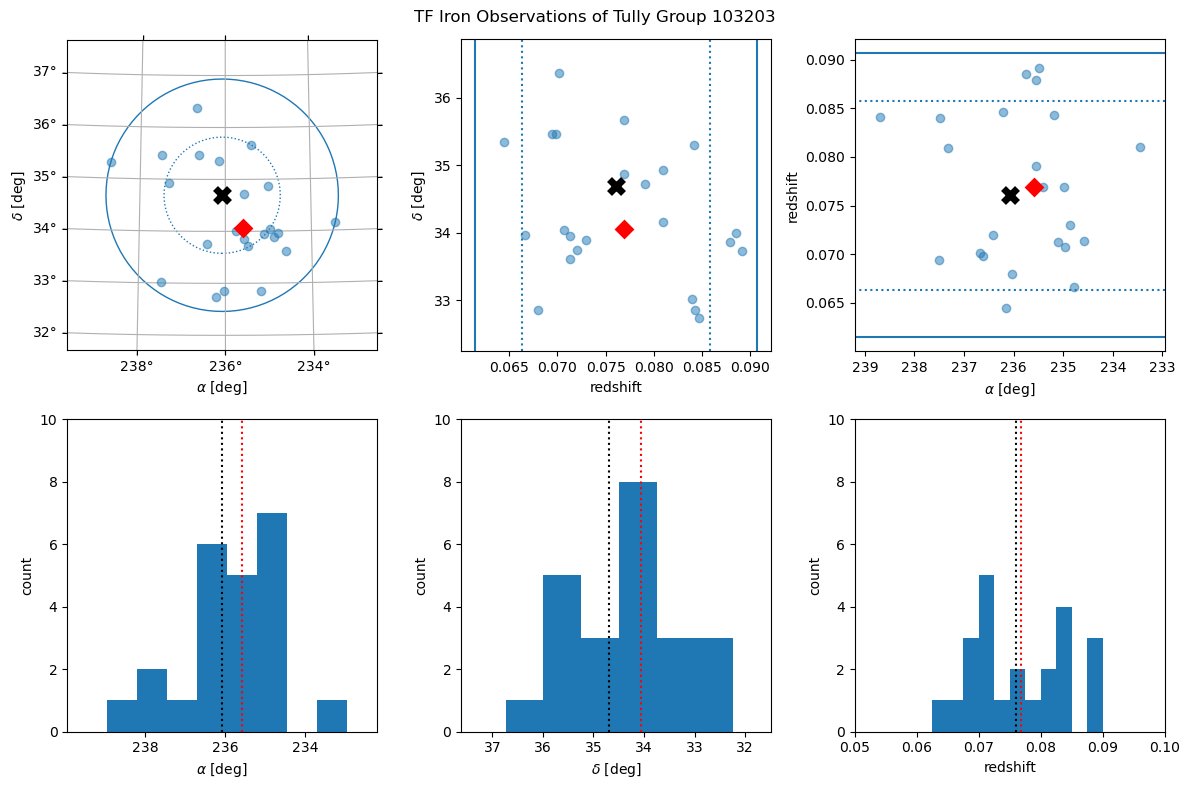

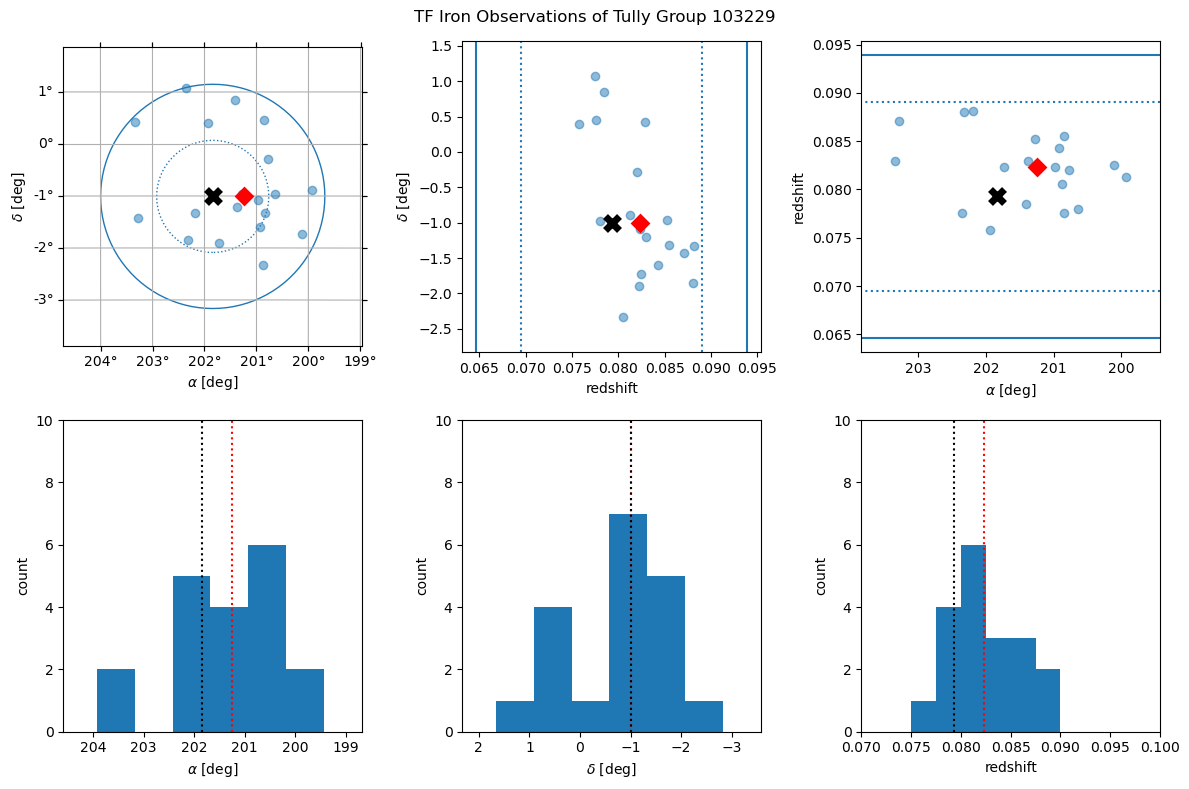

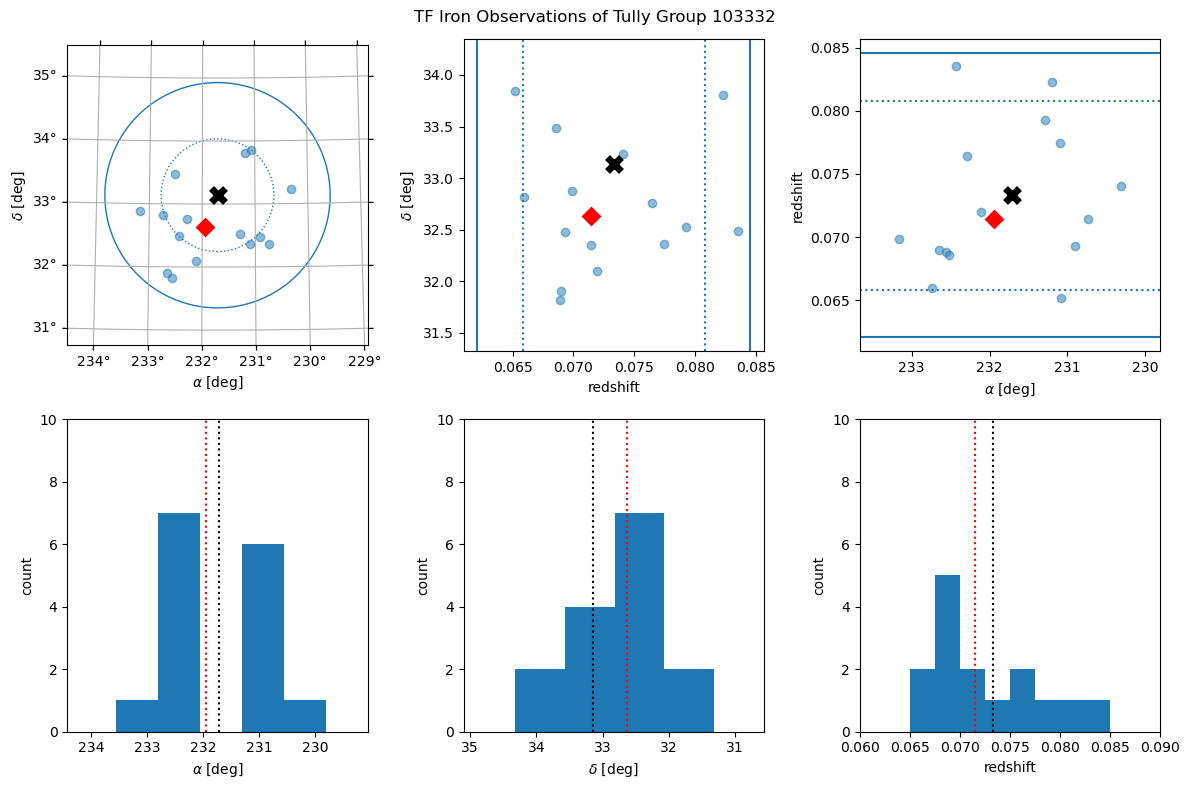

In [25]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100002       152.942 km/s     707.000 km/s       0.216      10.761 deg       5.510 deg       1.302
100007       161.856 km/s    1385.000 km/s       0.117       1.066 deg       1.395 deg       0.510
100042        94.762 km/s     545.000 km/s       0.174       0.507 deg       0.753 deg       0.449
100046       678.638 km/s     714.000 km/s       0.950       0.633 deg       0.764 deg       0.552
100058       943.391 km/s     781.000 km/s       1.208       0.132 deg       0.721 deg       0.122
100067       223.131 km/s     954.000 km/s       0.234       0.604 deg       0.961 deg       0.419
100077       294.144 km/s    1914.000 km/s       0.154       0.435 deg       1.222 deg       0.238
100081        88.183 km/s     635.000 km/s       0.139       0.104 deg       0.664 deg       0.104
100094       737.340 km/s     653.000 km/s       1.129       0.632 deg       0.699 deg       0.603
100282       898.691 km/s    2071.000 km/s       0.434       1.908 deg       1.156 deg       1.100
101400    

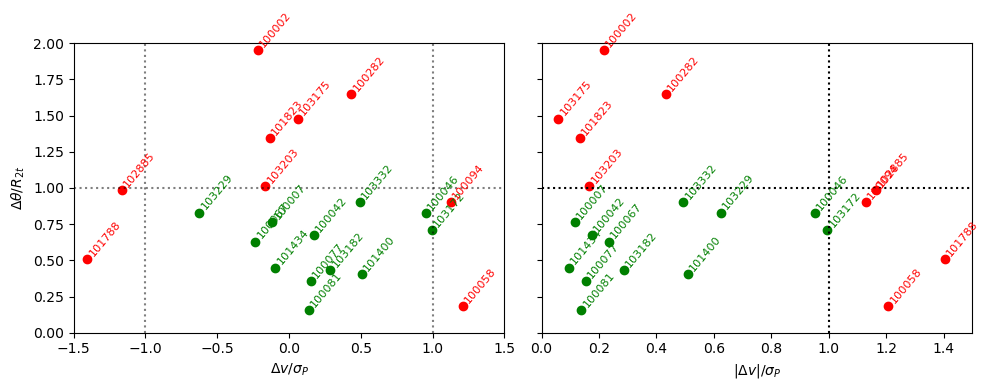

In [18]:
keep_cluster = []
dv_sigmaP = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigP = delta_v / cluster_sigma
    dv_sigmaP.append(_dv_sigP)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaP = np.asarray(dv_sigmaP)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1
select = (np.abs(dv_sigmaP) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaP[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaP[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaP[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaP[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_P$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaP[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_P$',
       xlim=(0, 1.5));

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_selection.png', dpi=150);

In [21]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100002  30 galaxies  N
 2  100007  20 galaxies  Y
 3  100042  19 galaxies  Y
 4  100046  17 galaxies  Y
 5  100058  25 galaxies  N
 6  100067  32 galaxies  Y
 7  100077  15 galaxies  Y
 8  100081  17 galaxies  Y
 9  100094  15 galaxies  N
10  100282  25 galaxies  N
11  101400  27 galaxies  Y
12  101434  18 galaxies  Y
13  101788  24 galaxies  N
14  101823  15 galaxies  N
15  102885  17 galaxies  N
16  103172  17 galaxies  Y
17  103175  18 galaxies  N
18  103182  27 galaxies  Y
19  103203  23 galaxies  N
20  103229  19 galaxies  Y
21  103332  15 galaxies  Y


## Plot Galaxy Clusters that Failed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 781 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (229.29825678, 7.14058993)>
10914.403364487573 +/- 653 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (159.82603928, 4.85617483)>
21978.598727848275 +/- 1636 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (227.0389939, -0.84791796)>
22803.420720004207 +/- 1973 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.99936671, 31.21107645)>
23550.492838960086 +/- 1707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (236.07424061, 34.69623742)>
22803.420720004207 +/- 1458 km/s


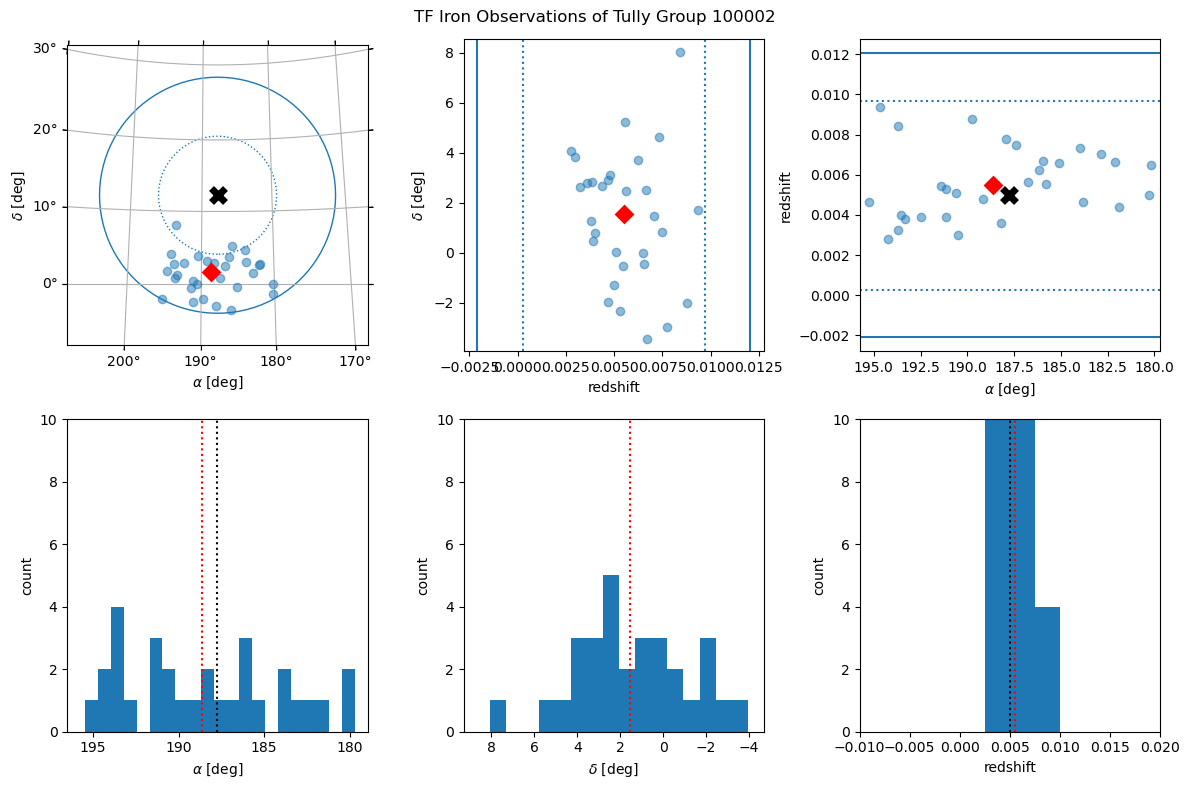

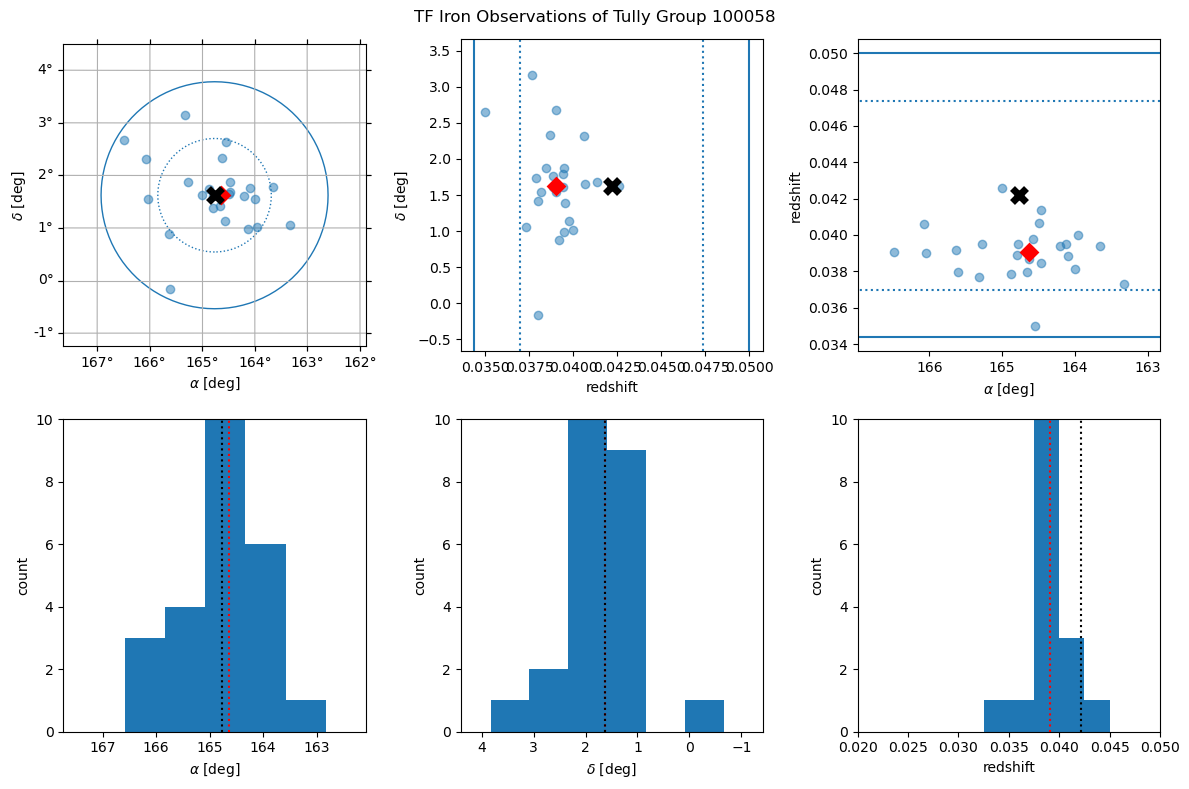

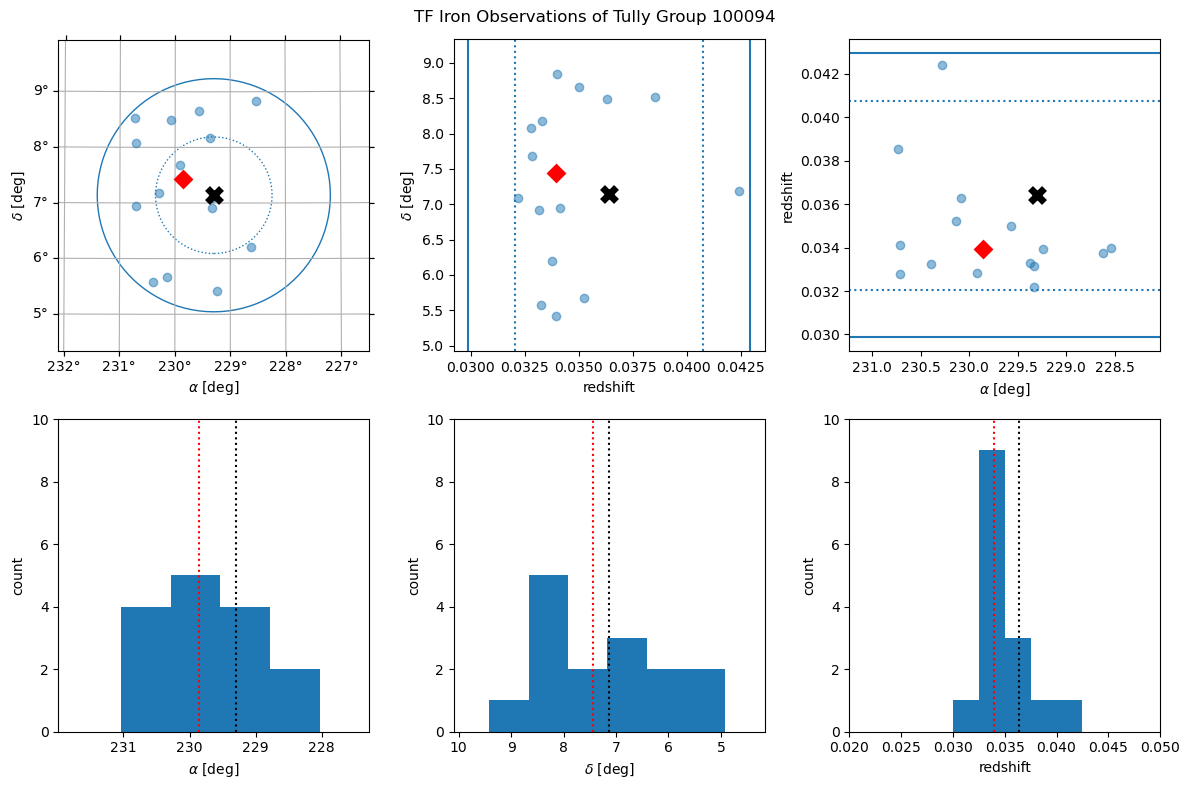

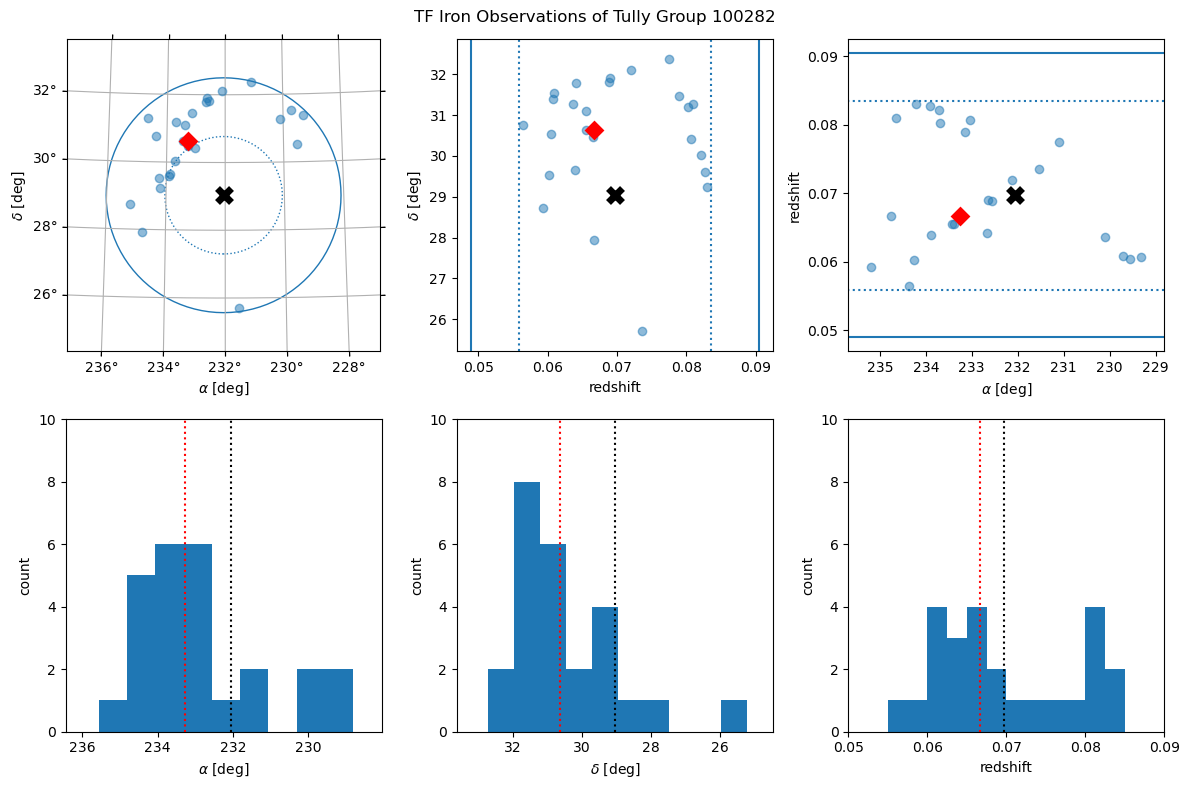

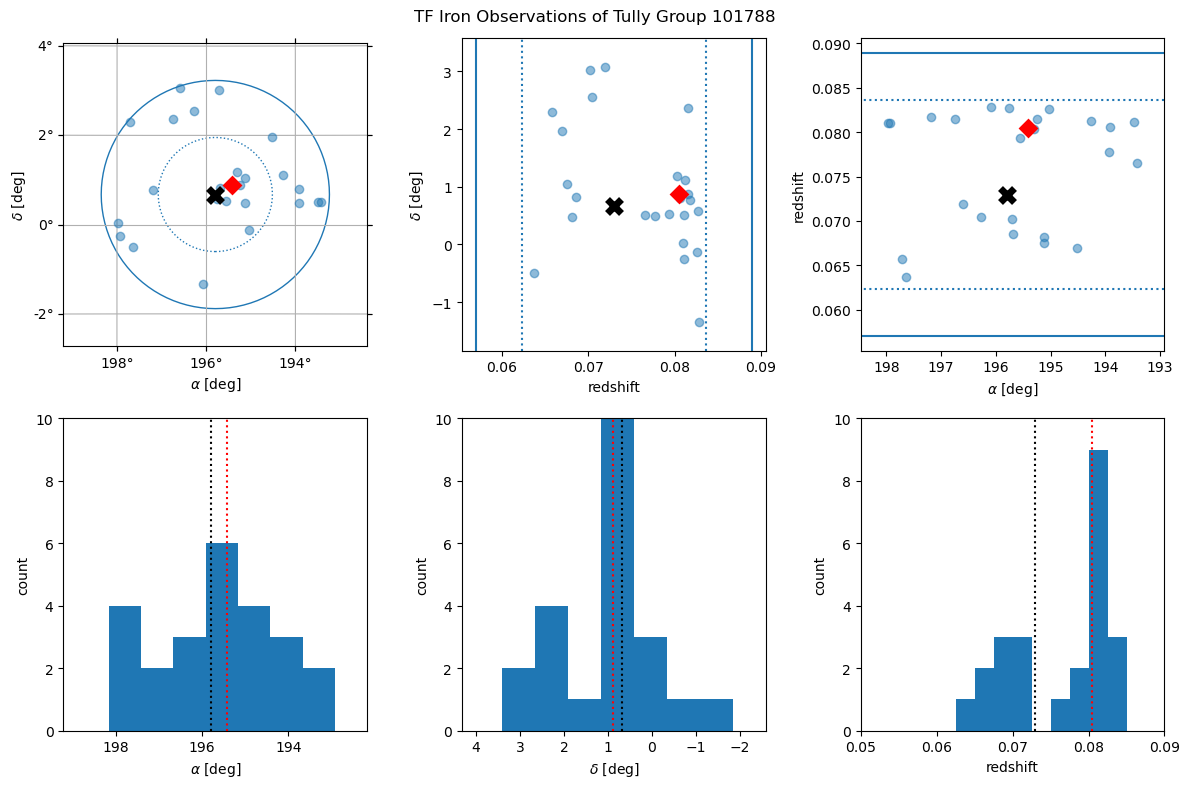

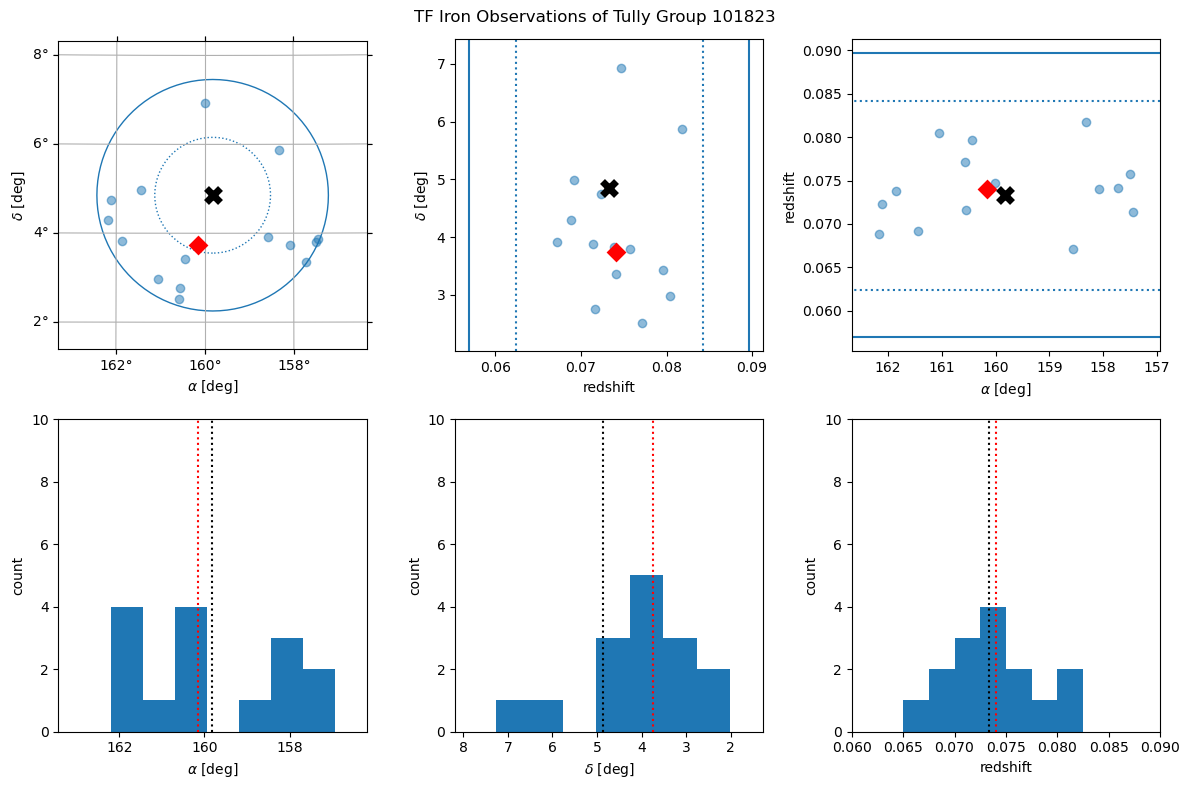

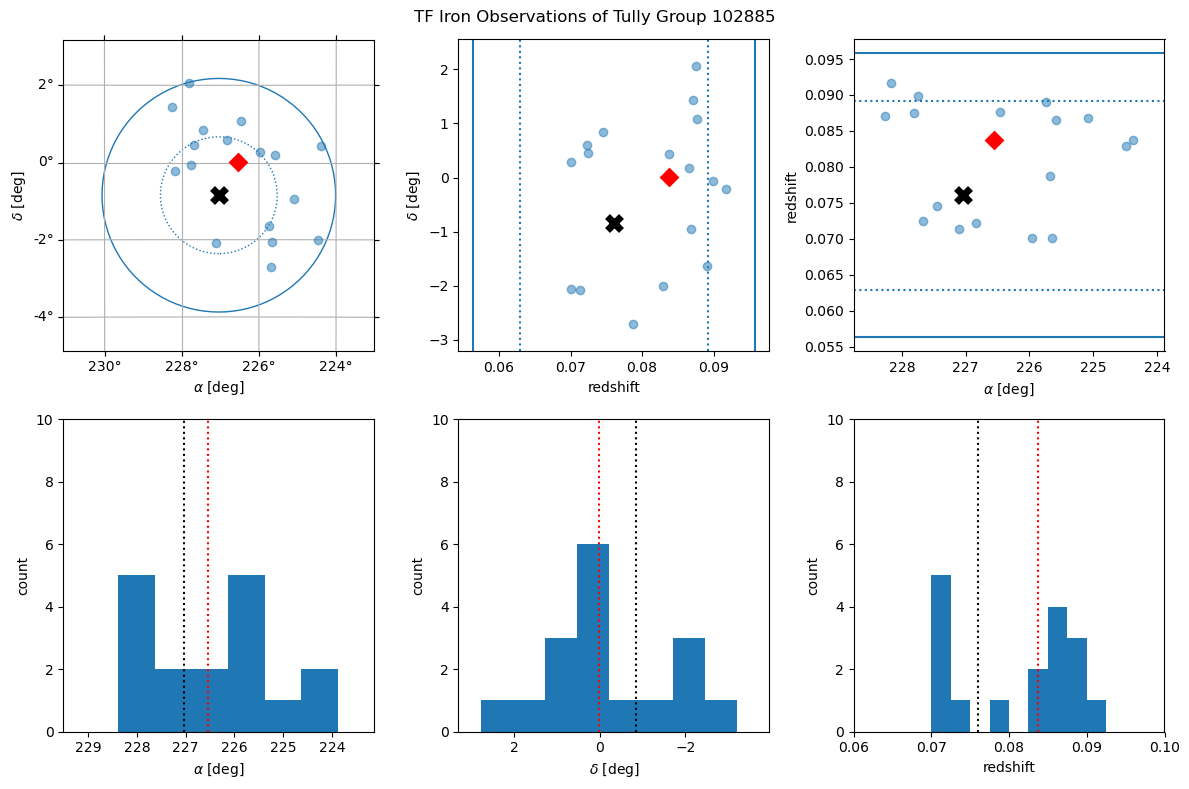

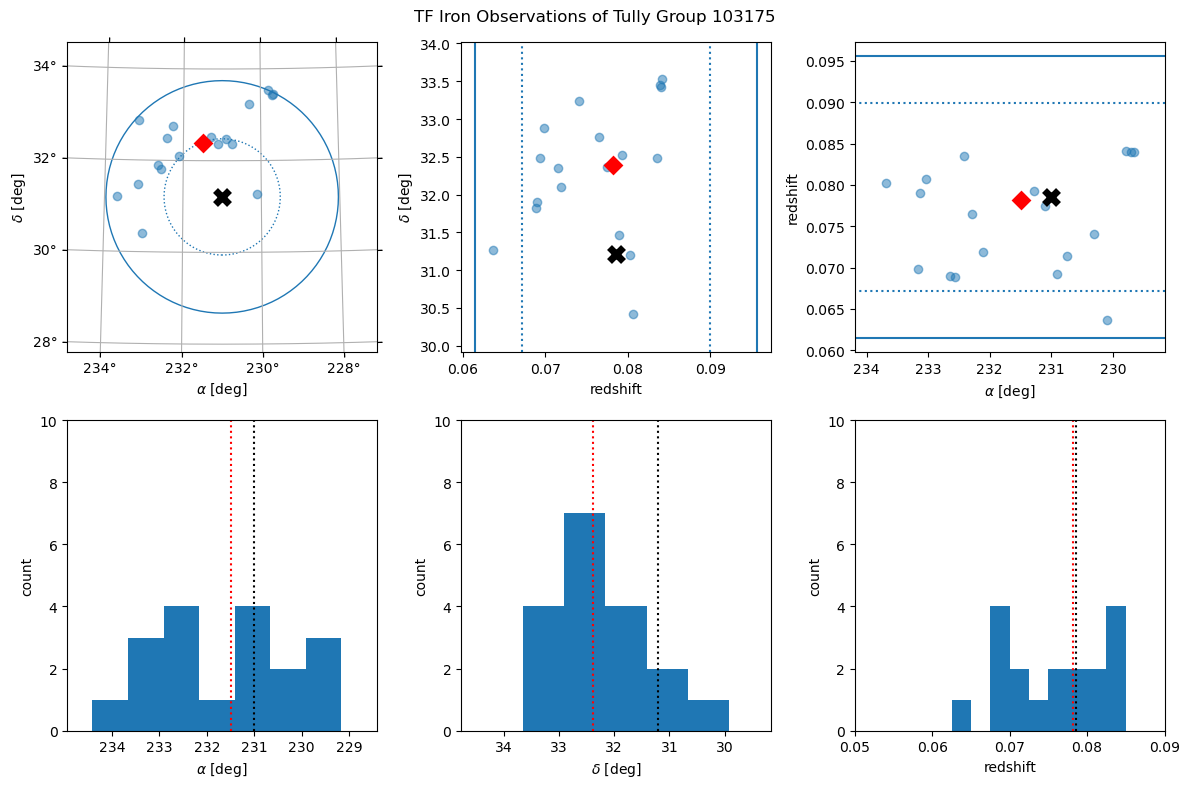

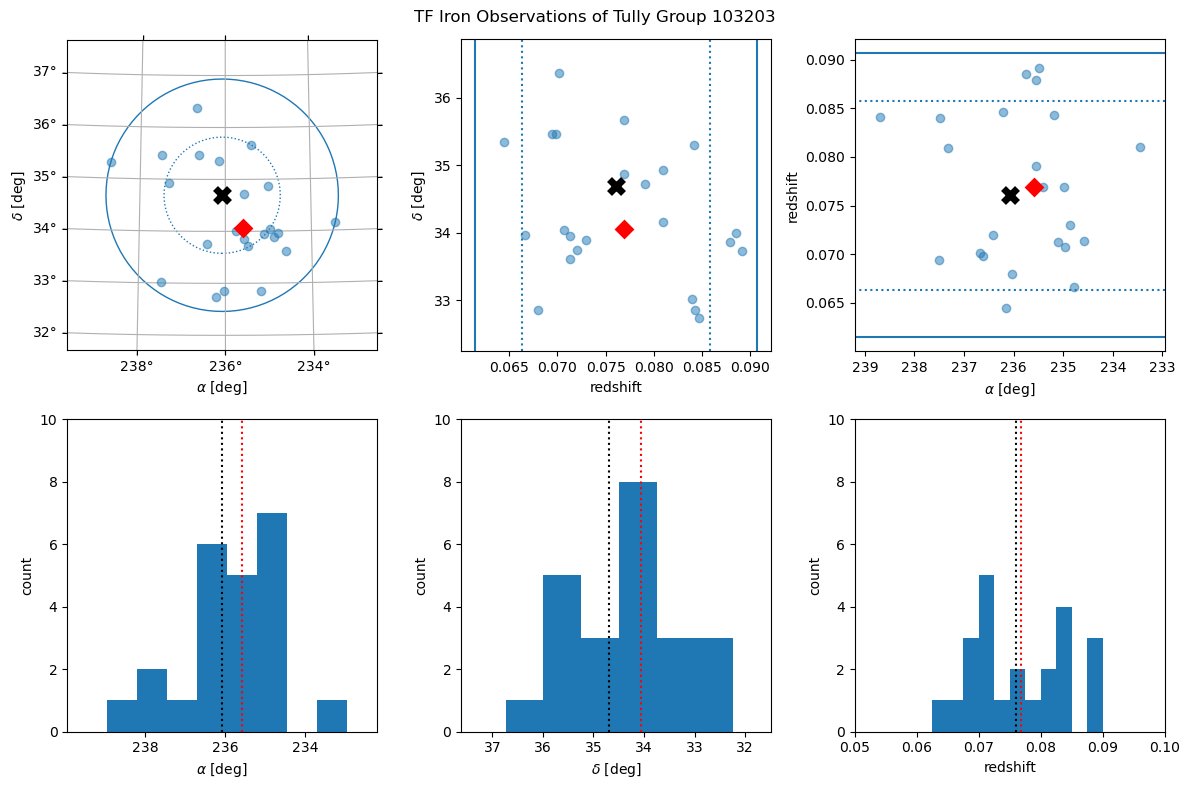

In [22]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 545 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (197.68010565, 34.27637749)>
11168.632477805635 +/- 635 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (233.44768796, 33.24483532)>
20701.413487910413 +/- 1196 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (237.23262377, 8.84560326)>
23014.418174085138 +/- 1823 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (206.10730715, 2.1097726)>
23120.647901755987 +/- 1693 km/s
<Sk

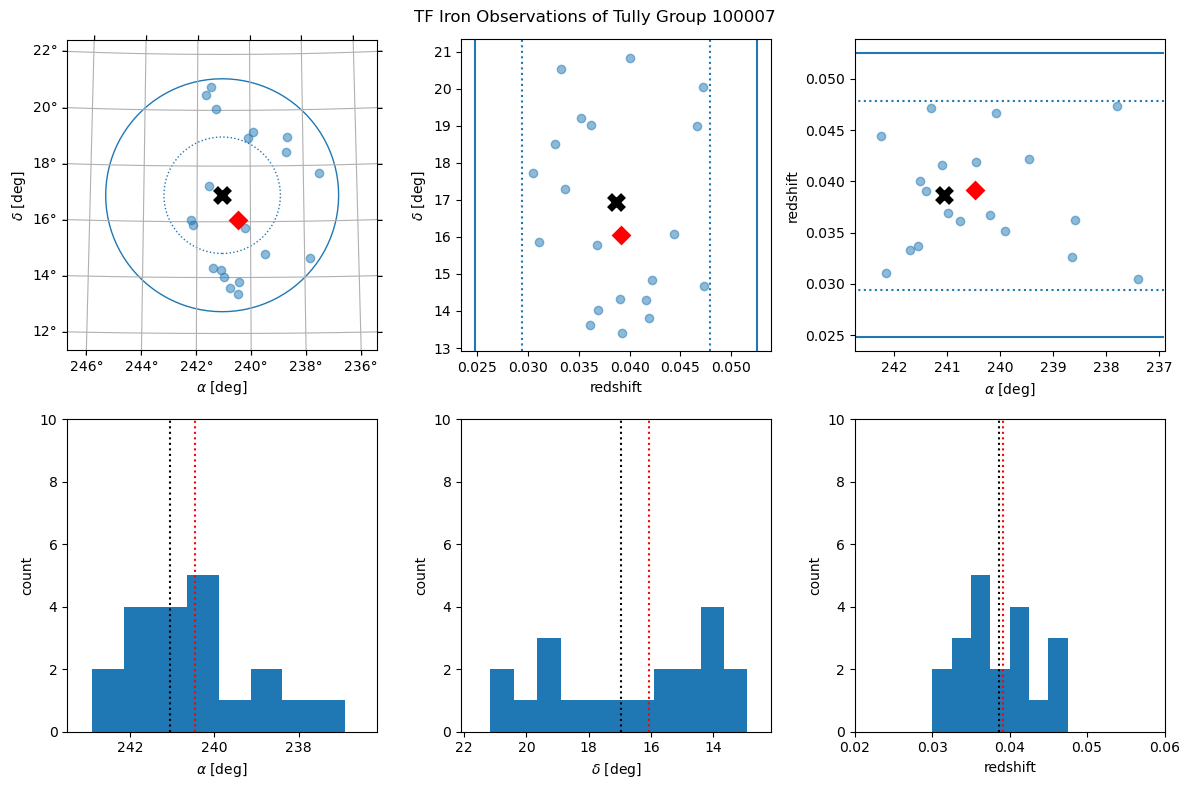

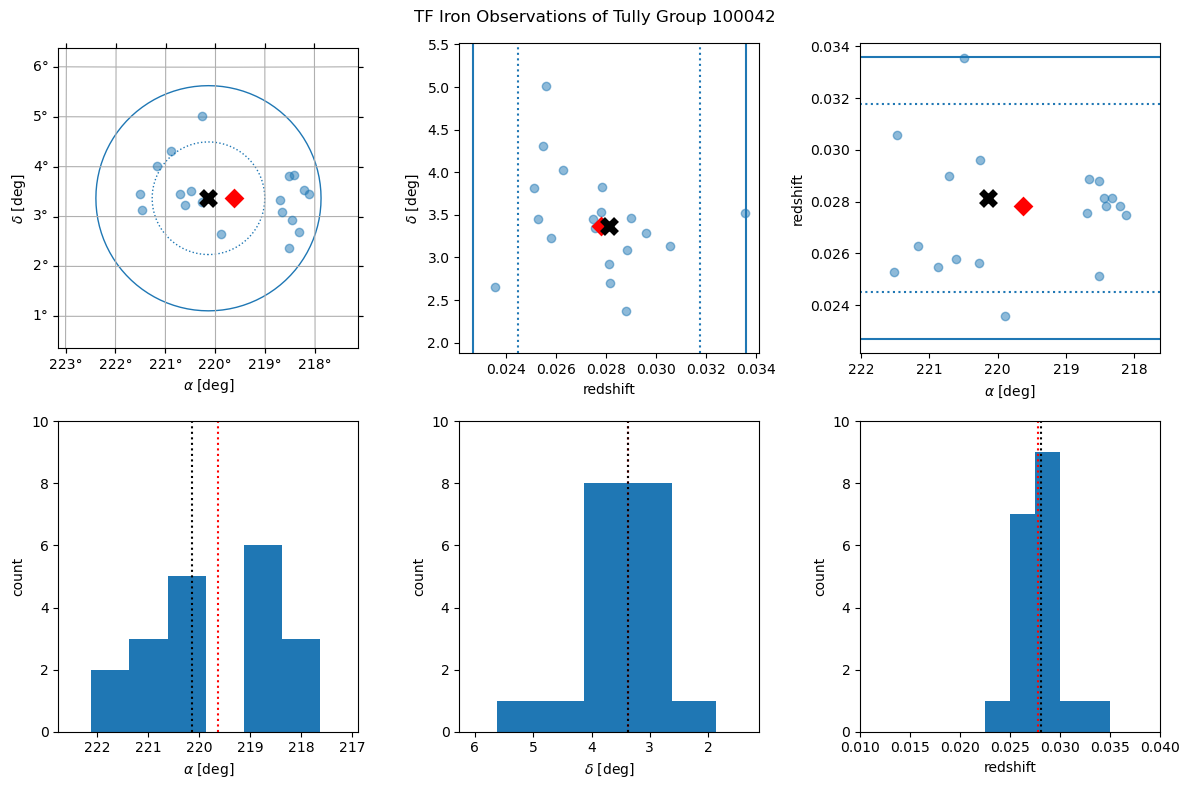

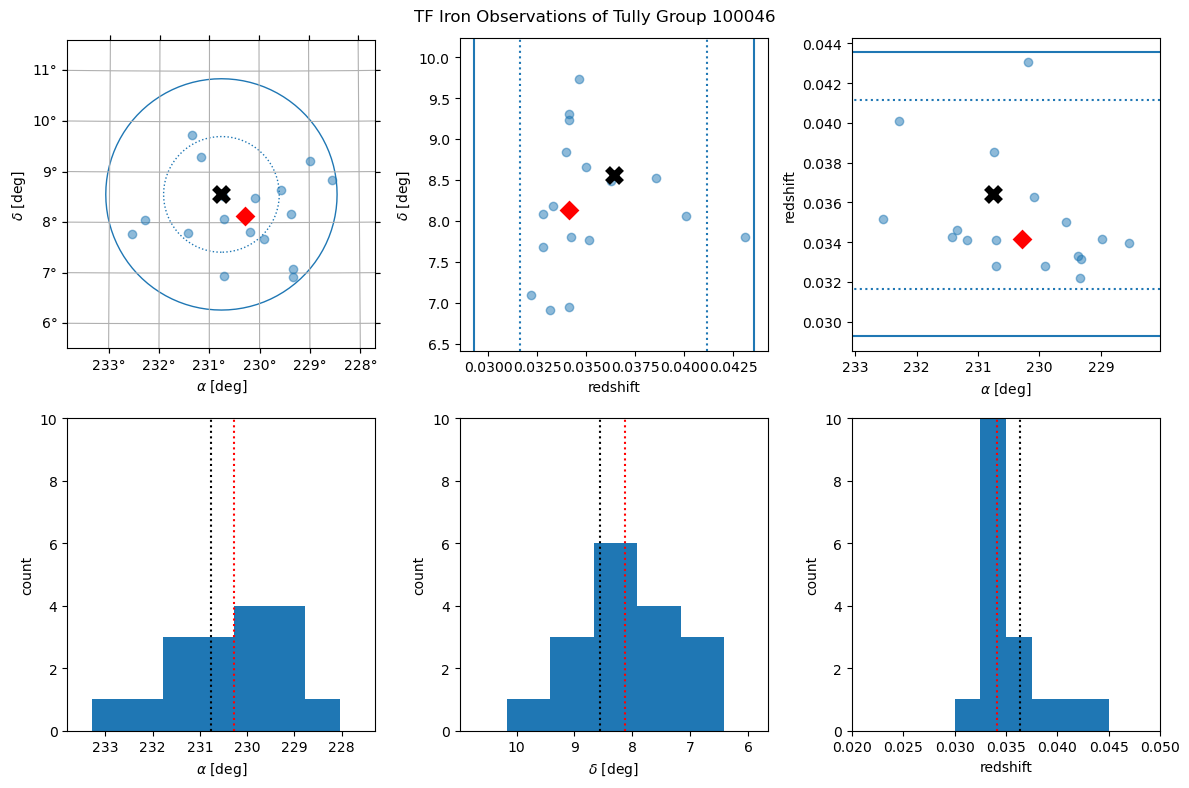

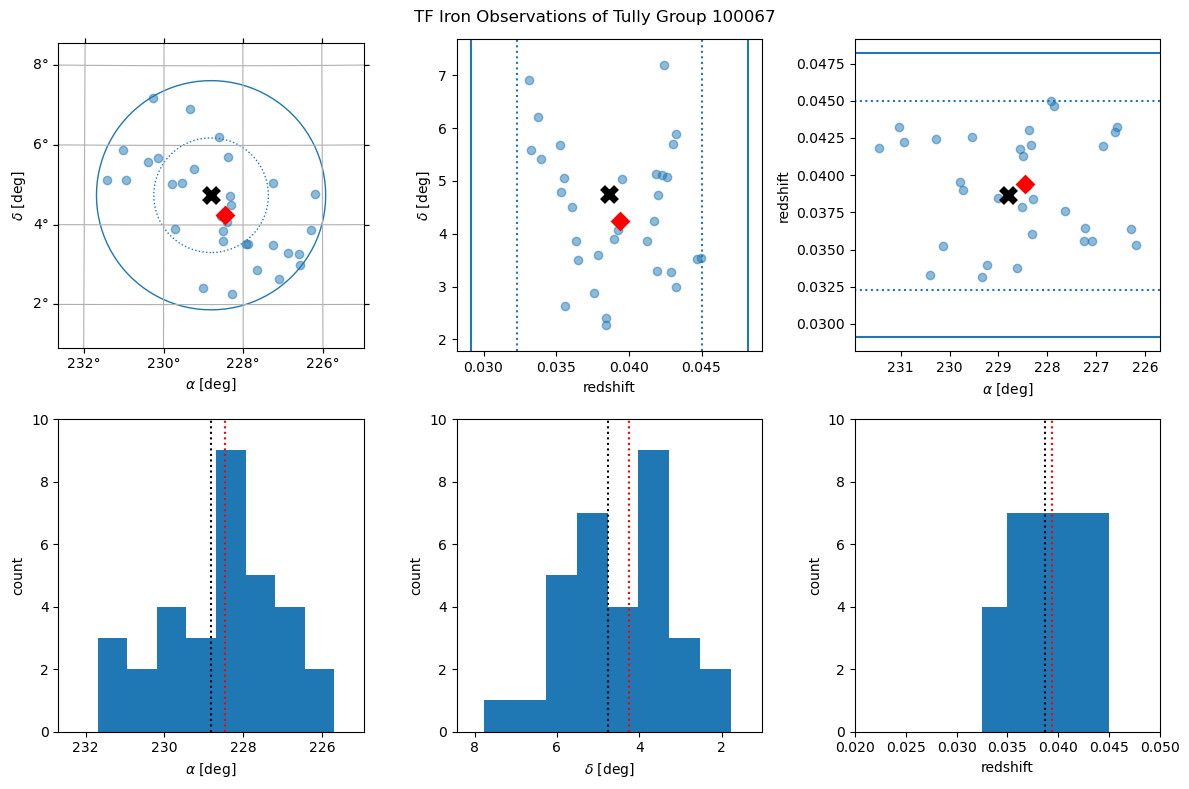

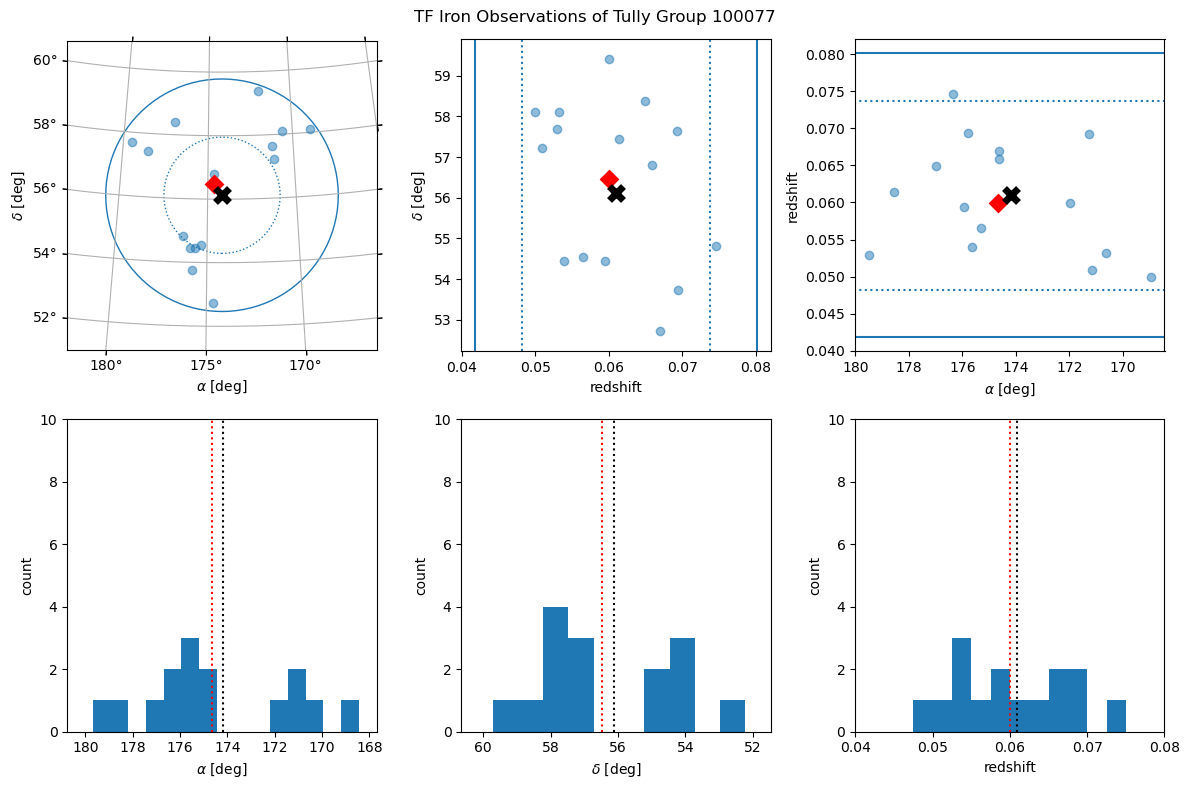

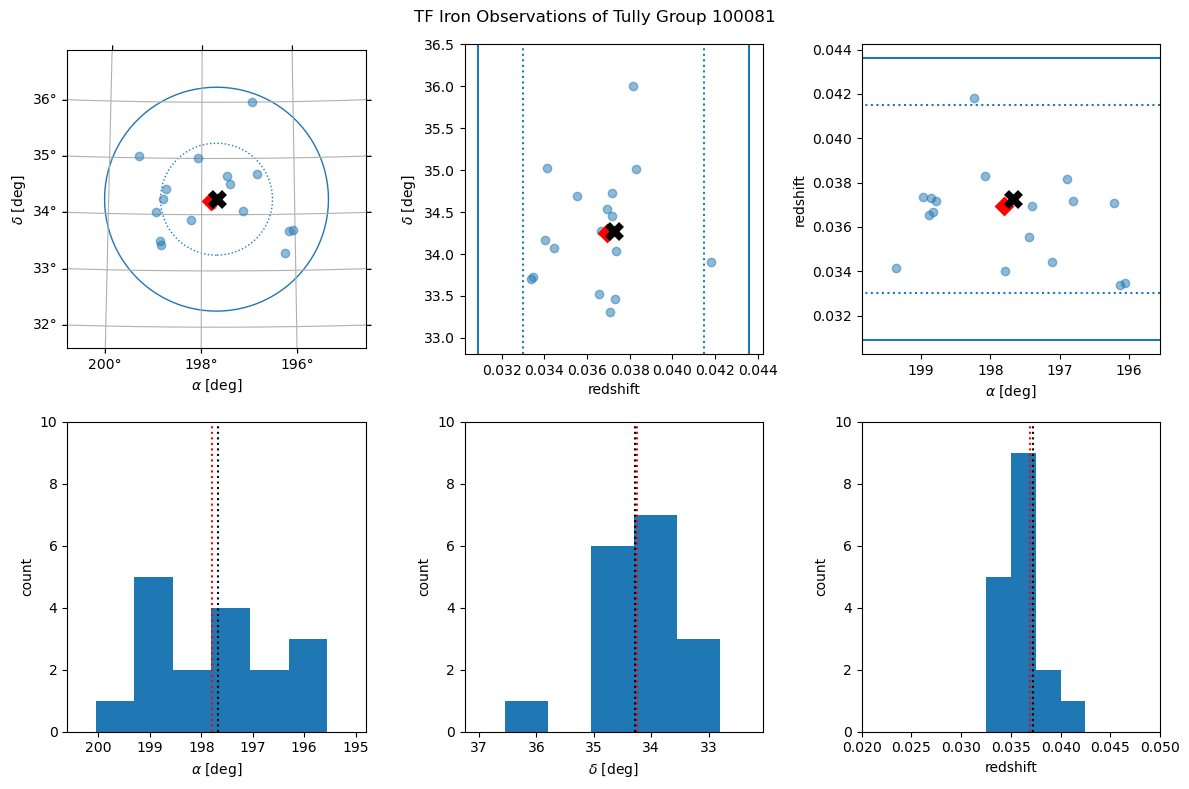

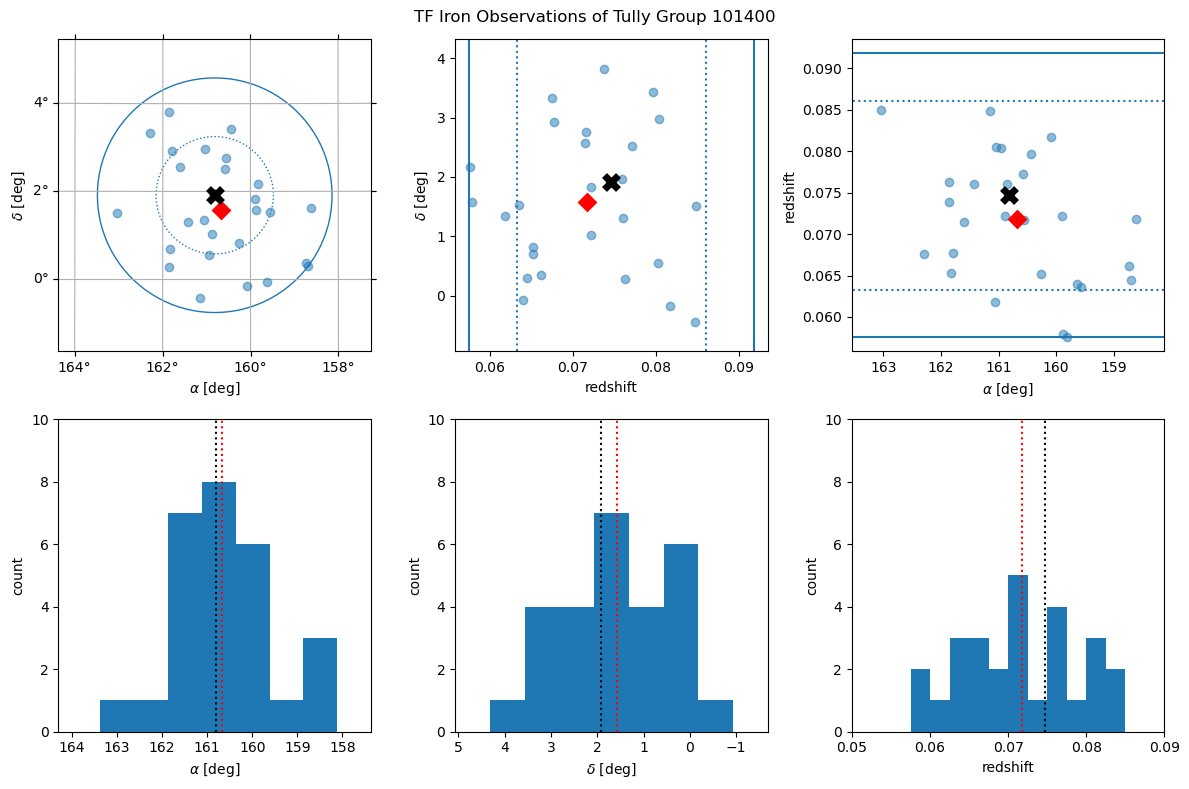

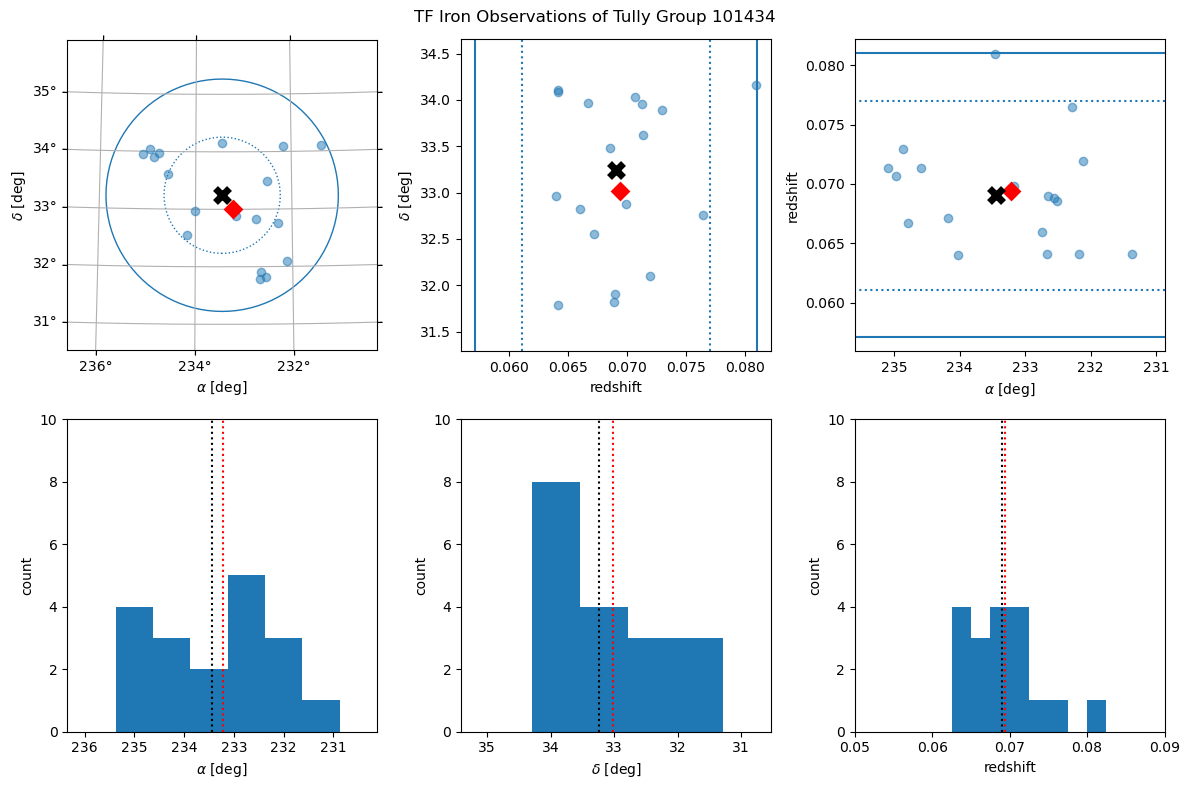

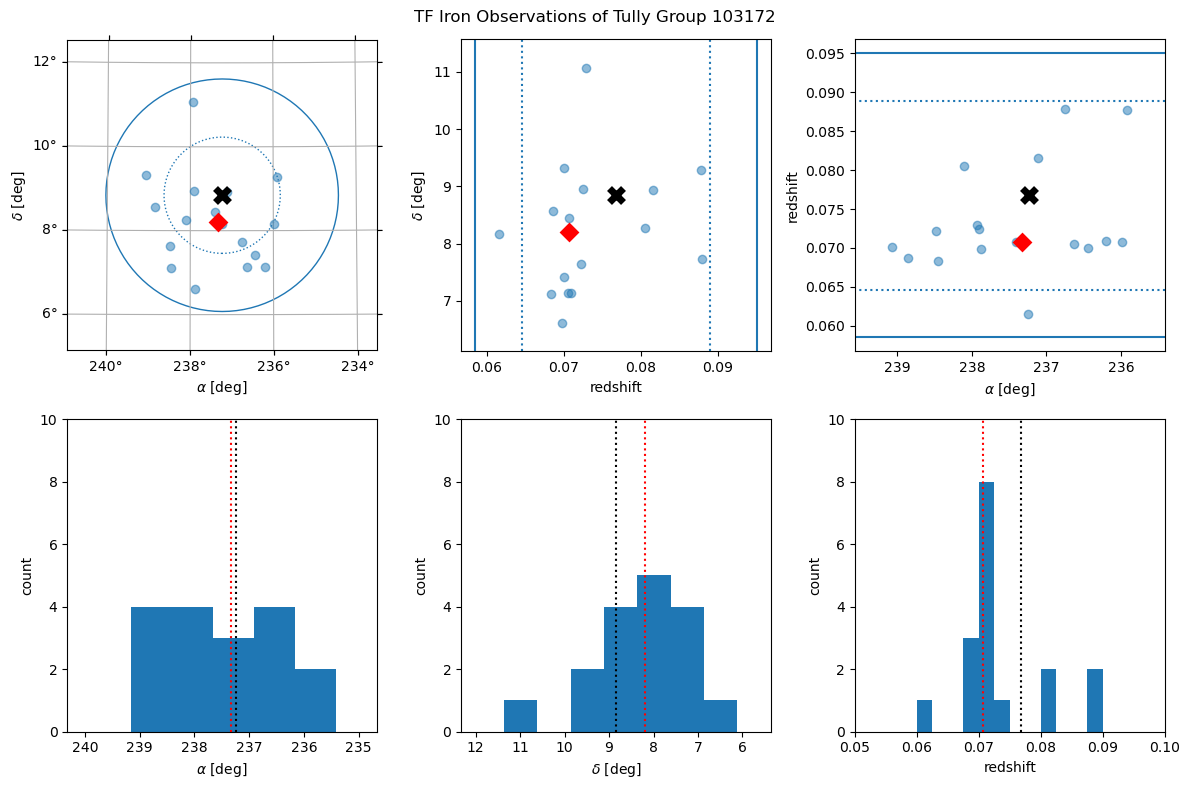

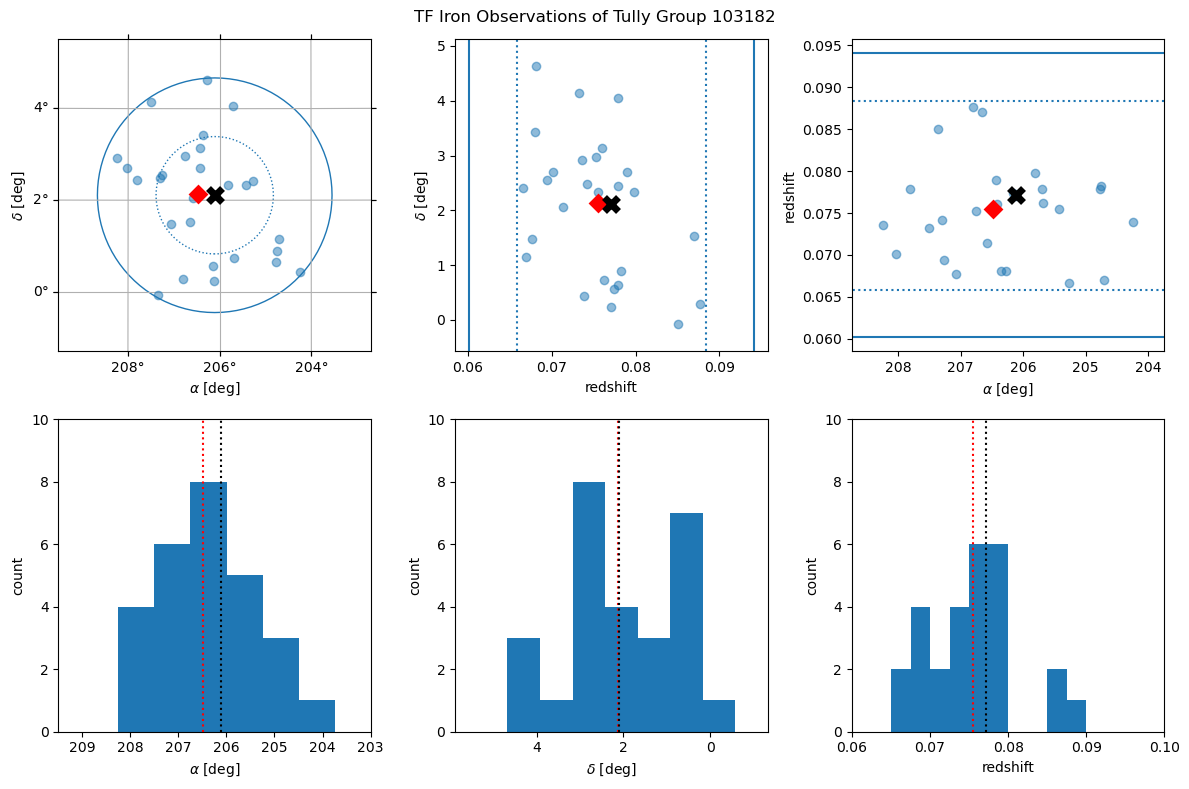

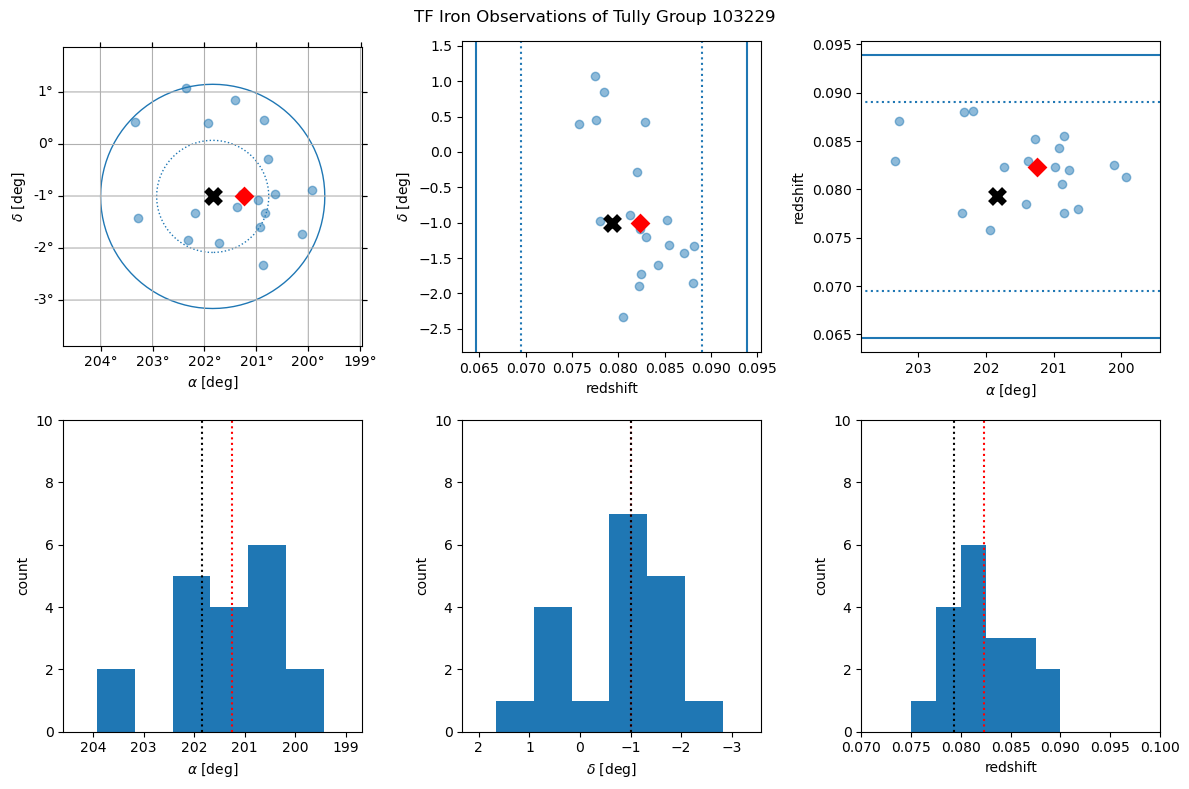

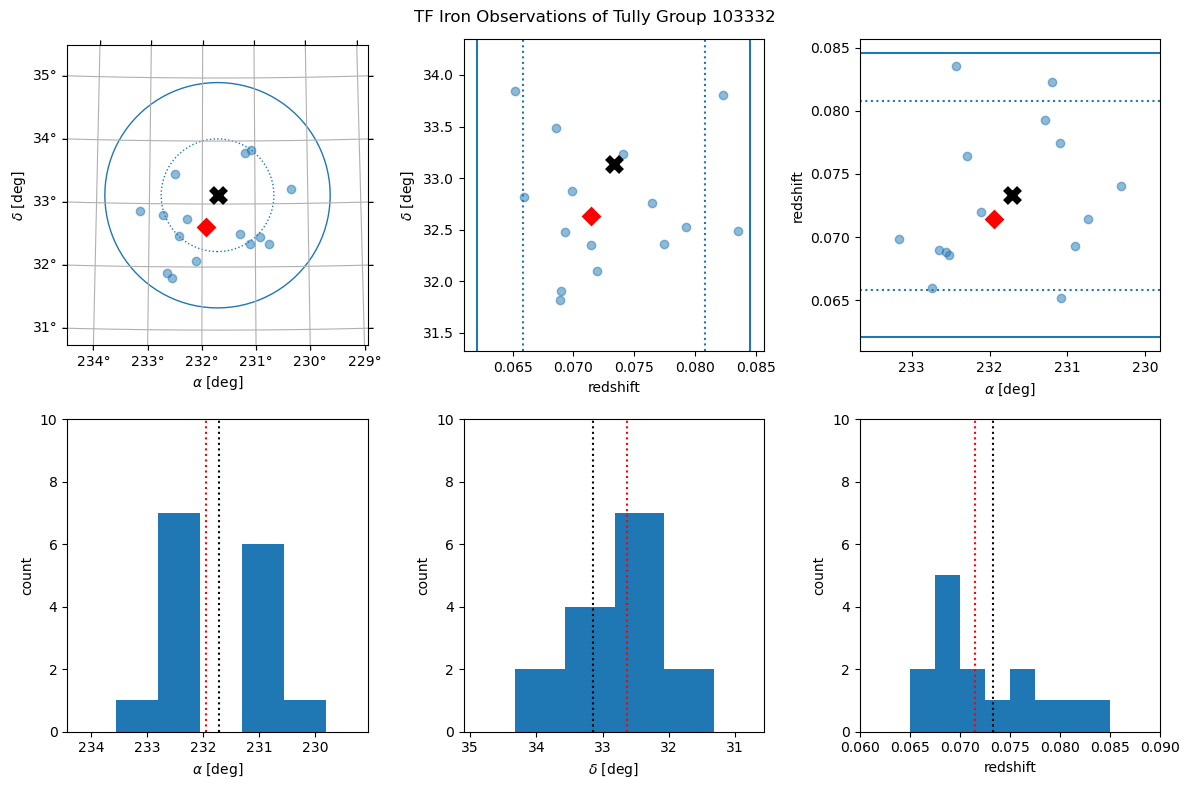

In [23]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [19]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

# caltab.write('SGA-2020_iron_Vrot_cluster_calib.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'V_0p4R26', 'V_0p4R26_err']][:5]

<Table length=5>
CLUSTER_ID SGA_ID R_MAG_SB26 ...      V_0p4R26         V_0p4R26_err   
  int32    int64   float32   ...      float64            float64      
---------- ------ ---------- ... ------------------ ------------------
    100007  33321   15.56614 ... 170.45255454239626 11.798759490473108
    100007 199506  16.979681 ... 112.16236269873289 6.4466500341938495
    100007 295688    16.0277 ... 170.51962169101327   1.95504691317512
    100007 364205  16.224758 ... 171.49200949131998  6.087025257106335
    100007 378878  16.529648 ...  84.50356548425552  1.525114010631534

In [20]:
rejtab

<Table length=192>
 SGA_ID    SGA_GALAXY             GALAXY         ... MORPHTYPE_AI CLUSTER_ID
 int64      bytes16              bytes29         ...    str10       int32   
------- ---------------- ----------------------- ... ------------ ----------
  93334   SGA-2020 93334               PGC041626 ...       Spiral     100002
 117242  SGA-2020 117242                 NGC4348 ...   Undecided      100002
 136291  SGA-2020 136291               PGC214054 ...       Spiral     100002
 149009  SGA-2020 149009                UGC06998 ...    Irregular     100002
 156492  SGA-2020 156492                UGC07911 ...   Undecided      100002
 200990  SGA-2020 200990               PGC044215 ...   Undecided      100002
 246089  SGA-2020 246089               PGC044474 ...       Spiral     100002
 254532  SGA-2020 254532                 NGC4409 ...       Spiral     100002
 293875  SGA-2020 293875              PGC1155762 ...       Spiral     100002
 516235  SGA-2020 516235                UGC07982 ...    Irregular     100002
    ...              ...                     ... ...          ...        ...
 904570  SGA-2020 904570              PGC2020999 ...       Spiral     103203
 908951  SGA-2020 908951  2MASXJ15392895+3353392 ...   Undecided      103203
 916496  SGA-2020 916496  2MASXJ15415566+3343259 ...       Spiral     103203
1011562 SGA-2020 1011562              PGC2064945 ...   Undecided      103203
1013644 SGA-2020 1013644              PGC2063167 ...   Undecided      103203
1013708 SGA-2020 1013708 SDSSJ153821.32+333659.3 ...       Spiral     103203
1186815 SGA-2020 1186815              PGC2056841 ...   Undecided      103203
1356304 SGA-2020 1356304              PGC2055751 ...       Spiral     103203
1377389 SGA-2020 1377389              PGC2015094 ...       Spiral     103203
1381083 SGA-2020 1381083 SDSSJ154300.28+335955.0 ...       Spiral     103203

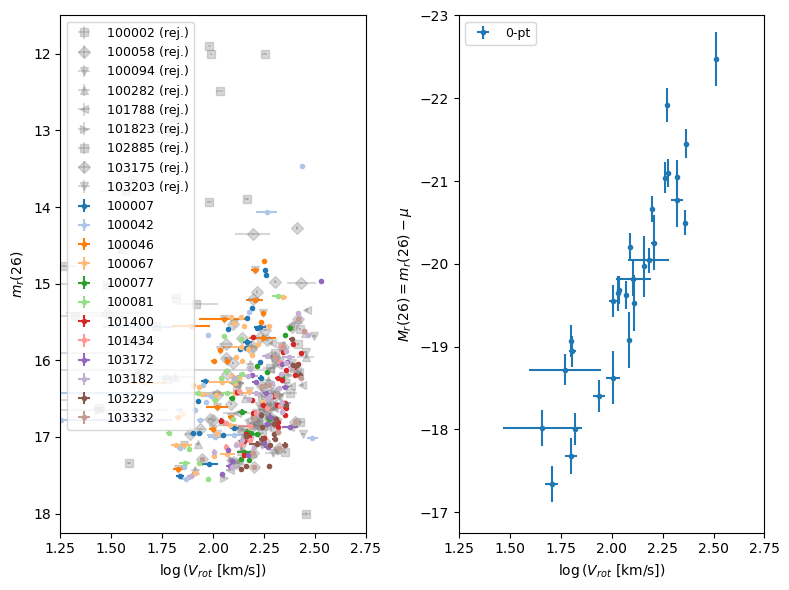

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
_cluster_ids = np.unique(rejtab['CLUSTER_ID'])
markers = 'sDv^<>'
for j, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26'][select_cluster].data
    mr26_err = rejtab['R_MAG_SB26_ERR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18.25, 11.5],
       ylabel=r'$m_r (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-16.75, -23],
       ylabel=r'$M_r(26) = m_r(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [21]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR'][select_cluster])

logV0 = 2.180104356466435


## Multiline Fit using HyperFit

In [22]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -11560.670400047973
     jac: array([ 0.00145519,  0.18353602, -0.10768416,  0.00563887, -0.01800799,
       -0.11168594, -0.00163709, -0.03201421,  0.17826095,  0.04911271,
        0.06330083,  0.06602931,  0.0167347 , -0.00291038, -0.27212081])
 message: 'Optimization terminated successfully.'
    nfev: 39165
     nit: 172
 success: True
       x: array([ -6.75182386, -20.41901657,  15.56969033,  15.22926442,
        15.29771169,  15.54309227,  16.87852141,  15.45892114,
        17.16697588,  16.94375563,  17.09647847,  16.87317849,
        17.53432   ,  17.25529679,   0.57116257])
Ndim: 15 13


100%|██████████| 1000/1000 [00:40<00:00, 24.97it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.44960506 72.66948574 68.49769575 64.05828622 70.50095682 72.16691078
 77.98414794 66.59118522 71.46299023 72.67587063 68.99115561 75.09179483
 70.13274702 67.88782836 67.62164414] / 3899.2073972319345


100%|██████████| 1000/1000 [00:40<00:00, 24.97it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [88.47603864 84.11064238 86.18759867 89.34702885 86.66465634 88.44959717
 87.34544255 89.19309735 82.89370113 93.57602596 76.38652575 90.69510861
 85.16882739 84.53416266 85.11713069] / 4678.801298105242


100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.99416689 105.87510455  99.87405771  95.49564217 102.913384
  99.91456756  99.4085081  101.02098685  96.00456835 101.2190406
  89.97007623 105.36127336 103.15827985  93.1707986   92.55995691] / 5293.755227501536


100%|██████████| 1000/1000 [00:38<00:00, 25.81it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [114.89958826 109.45842239 108.89345644 112.53239207 106.76093845
 109.34206165 108.26684793 110.19659637 104.92793364 106.38673479
  96.76934058 110.28461987 111.14690397 113.58416282 112.96395618] / 5744.979412819383


100%|██████████| 1000/1000 [00:36<00:00, 27.19it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.55079405 112.77934402 108.78590938 126.60666711 113.39665544
 116.53968388 116.14775005 109.93871905 108.29330572 120.14250834
 107.1900564  122.92030767 110.19923489 127.46308319 127.33213049] / 6373.154159543634


100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [133.39682591 118.72367036 110.54927764 123.92443904 120.79167582
 126.78744548 119.04430136 112.16657341 107.83486826 124.50799165
 112.79078922 135.34425957 117.43577212 126.05814956 126.59839753] / 6767.2129787337735


100%|██████████| 1000/1000 [00:36<00:00, 27.32it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.18221998 114.23265096 120.32978725 135.12682214 121.89236911
 138.24837435 121.22207715 119.41124166 124.69488397 127.75903384
 119.51885995 134.12830923 118.51835254 128.54845436 112.88540566] / 6912.418717272256


100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [126.57031568 121.74608893 121.32696409 141.37752112 120.52468639
 150.99043991 128.93415293 128.33703758 131.75994045 126.94596137
 126.66266724 134.34994349 123.81464841 135.22225403 123.66641322] / 7549.521995725538


100%|██████████| 1000/1000 [00:38<00:00, 25.98it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.43218251 122.31843654 128.12201944 140.59651384 120.21684505
 151.6897415  127.19988201 133.70177904 146.66350666 141.96317141
 134.50538046 139.05727076 126.79896265 132.59301467 136.38508873] / 7584.487075002812


100%|██████████| 1000/1000 [00:36<00:00, 27.04it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [146.59476451 138.83434502 132.13460375 139.65265647 121.27820549
 144.34628013 130.99496449 135.62114374 148.37679971 140.16905266
 134.33405809 130.23294995 127.3857736  129.56179517 147.94697917] / 7418.83998567687


100%|██████████| 1000/1000 [00:38<00:00, 25.79it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.95169076 143.74678261 140.19456773 147.23635571 127.7242678
 150.98436761 135.88425341 138.54194203 151.10434698 157.86043104
 134.55804886 129.88676042 137.93196008 138.37349483 152.48252332] / 7893.021552065503


100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.23111589 146.72219536 138.18905391 149.31755104 130.98963613
 147.86715356 144.71118126 142.35882131 150.14215821 149.92712919
 137.48642859 128.30090507 134.61021593 139.35179568 150.19859854] / 7509.929926839879


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.96771695 149.20060041 142.52813163 149.81776488 141.1865311
 138.89620628 150.68804766 146.34787835 153.68657009 151.01546809
 139.68893443 133.34444644 143.22281171 142.21599866 151.7690302 ] / 7684.328504706599


100%|██████████| 1000/1000 [00:40<00:00, 24.81it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.13566613 142.45099565 147.45593857 147.93822009 147.36057993
 137.07174446 152.03250212 147.90740406 152.02809032 150.12722979
 140.28547466 137.70074291 142.98580954 146.20605823 152.77031106] / 7856.783306579854


100%|██████████| 1000/1000 [00:38<00:00, 26.05it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.53322103 136.0601738  151.93035782 148.26098436 148.63158998
 143.05497124 152.93131053 150.67015641 150.67756447 151.40780024
 143.36391278 140.3540073  138.53943269 149.915013   155.15130809] / 7826.661051595134


In [23]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs_KAD.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

In [39]:
#- Run the MCMC
# mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=20000, verbose=True)#, skip_initial_state_check=True)
# print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

 message: Optimization terminated successfully.
 success: True
     fun: -8250.779085181553
       x: [-6.408e+00 -2.085e+01  1.515e+01  1.518e+01  1.670e+01
            1.663e+01  1.642e+01  1.686e+01  1.706e+01  5.192e-01]
     nit: 134
    nfev: 20393
     jac: [ 9.259e-02  6.003e-03  5.457e-04  2.237e-02 -8.731e-03
           -3.820e-02 -6.894e-02 -5.039e-02 -5.693e-02  6.858e-02]
Ndim: 10 8


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 179.96it/s]


Niterations/Max Iterations:  1000 / 20000
Integrated ACT/Min Convergence Iterations:  [57.6355728  51.5145842  55.83092114 55.84533742 51.05928875 49.09594238
 57.21213737 52.85823244 61.75772278 52.5888957 ] / 3087.8861391082073


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.08it/s]


Niterations/Max Iterations:  2000 / 20000
Integrated ACT/Min Convergence Iterations:  [69.58643628 68.35673838 69.45597504 66.11792789 56.91382711 63.77592065
 65.15915143 67.45694014 68.32274921 88.35001784] / 4417.50089181856


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.84it/s]


Niterations/Max Iterations:  3000 / 20000
Integrated ACT/Min Convergence Iterations:  [73.94612692 85.71703869 77.56311397 70.96380781 75.79511317 68.22281965
 71.68941263 77.61925377 74.46950971 85.23920129] / 4285.851934264271


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 182.15it/s]


Niterations/Max Iterations:  4000 / 20000
Integrated ACT/Min Convergence Iterations:  [91.66476416 86.11102709 80.48308205 73.97322472 76.92654538 79.49886764
 78.78919078 92.04593016 83.1380075  84.53266181] / 4602.296508132472


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.28it/s]


Niterations/Max Iterations:  5000 / 20000
Integrated ACT/Min Convergence Iterations:  [89.34975333 87.57110803 82.45810186 85.46497313 83.64539631 82.51491143
 76.43433713 92.09380954 77.78407136 84.4910166 ] / 4604.690477070015


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.78it/s]


Niterations/Max Iterations:  6000 / 20000
Integrated ACT/Min Convergence Iterations:  [101.66499682  91.88812052  83.19109387  97.69422659  84.21897509
  85.40840091  85.71392075  97.78504334  72.71122311  92.97884759] / 5083.249840841896


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.28it/s]


Niterations/Max Iterations:  7000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 95.06266965  92.04063088  93.56908699 104.90392892  91.68767166
  93.14676391  94.36393044  99.83360859  79.93320762  95.49811567] / 5245.196446083893


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.13it/s]


Niterations/Max Iterations:  8000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 95.7762937   92.47066508  90.78989927 104.38773097 100.08169698
  98.77075246  93.78132958 101.39712972  81.87505934  97.77511458] / 5219.386548613297


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.71it/s]


Niterations/Max Iterations:  9000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 96.75180275  93.21597595  93.34069471 109.47903377  99.4028329
 107.15813686  96.01266434 101.0014179   89.00302921  98.79964008] / 5473.951688658702


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.32it/s]


Niterations/Max Iterations:  10000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 92.25056912  92.71484889 100.74923903 106.91625979  94.45706441
 105.3037386   97.48142128 102.36459546  98.48287485  93.59483004] / 5345.81298967049


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.68it/s]


Niterations/Max Iterations:  11000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 90.20031303  94.80758725 102.94157014 101.49388399  99.9754158
 107.58788255 101.28995026  99.9447067   96.36209187  92.62303202] / 5379.394127335317


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 176.68it/s]


Niterations/Max Iterations:  12000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 96.46045311  92.48333011 103.80003724 106.66185464  98.21056199
 104.05081833 102.53940629  96.43616215 101.40910279  93.96144554] / 5333.09273211555


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 175.34it/s]


Niterations/Max Iterations:  13000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 95.94696683  94.02713561 100.15520996 101.0181298   97.89253628
 100.7121743  103.96565194  94.43683705 108.53676074  94.73688382] / 5426.838037057847


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 176.62it/s]


Niterations/Max Iterations:  14000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 96.85410663  95.81631081 100.90223615  95.7525556  104.74965508
 100.28243586  99.65595228  94.92146551 109.89275349  92.38893016] / 5494.637674662946


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 173.48it/s]


Niterations/Max Iterations:  15000 / 20000
Integrated ACT/Min Convergence Iterations:  [100.82825364  97.19675869  99.93761247  93.71531689 103.061679
 101.98211408 102.18596217  94.49594578 106.33035239  97.07581282] / 5316.517619426099
[ -6.41809404 -20.85510804  15.1443254   15.18251548  16.69696276
  16.62737442  16.41642144  16.86315275  17.06319999   0.52096406] [0.07248798 0.02454799 0.02898534 0.02223003 0.02323949 0.03168029
 0.02009183 0.02850744 0.03568263 0.00815966]


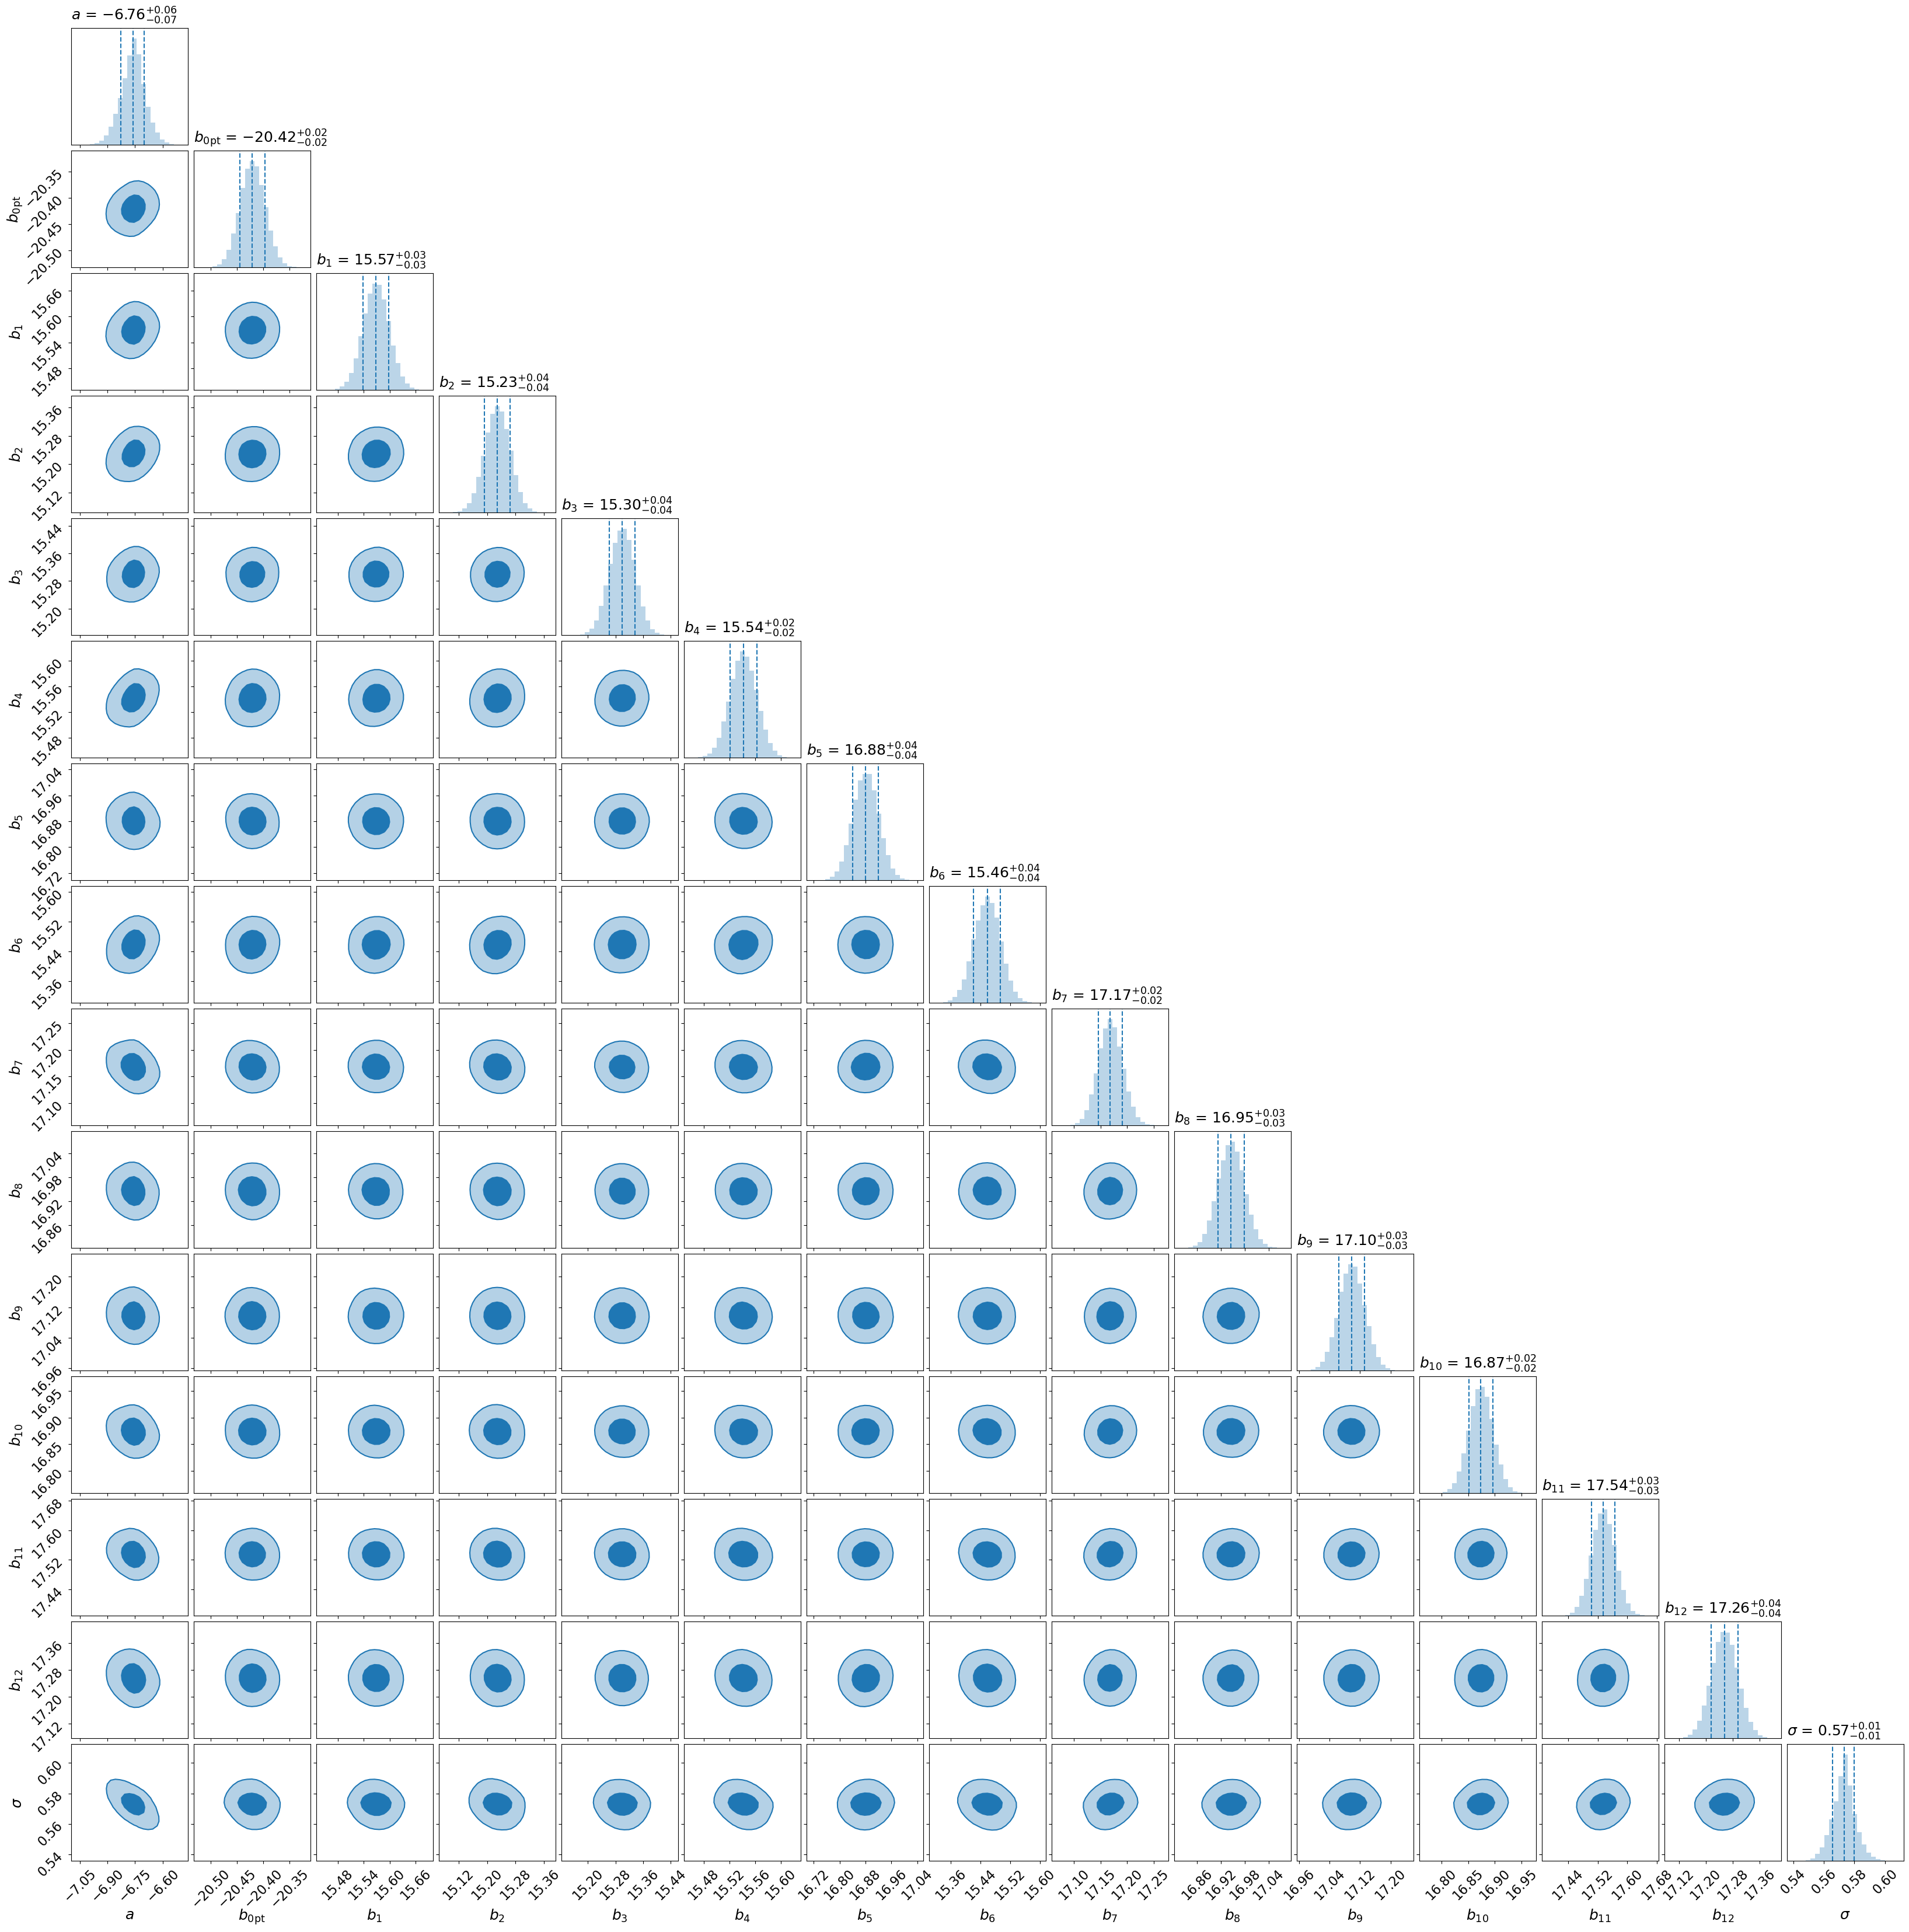

In [24]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_corner0.png', dpi=150);

### Plot the HyperFit Results

In [25]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

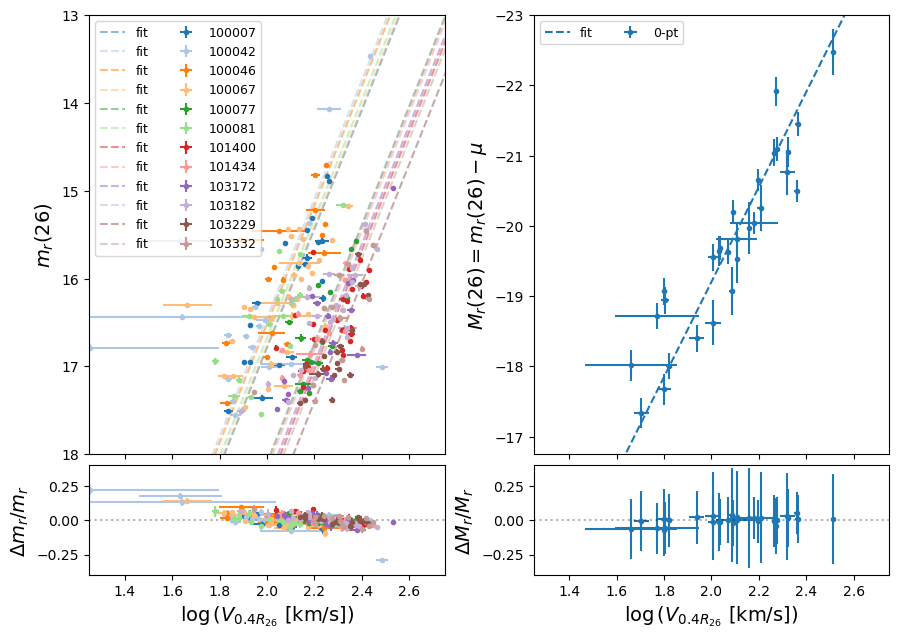

In [26]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label='fit')

ax.set(xlim=[1.25, 2.75],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r (26)$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -23])
ax.set_ylabel(r'$M_r(26) = m_r(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.75],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.75],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_fit0.png', dpi=150)

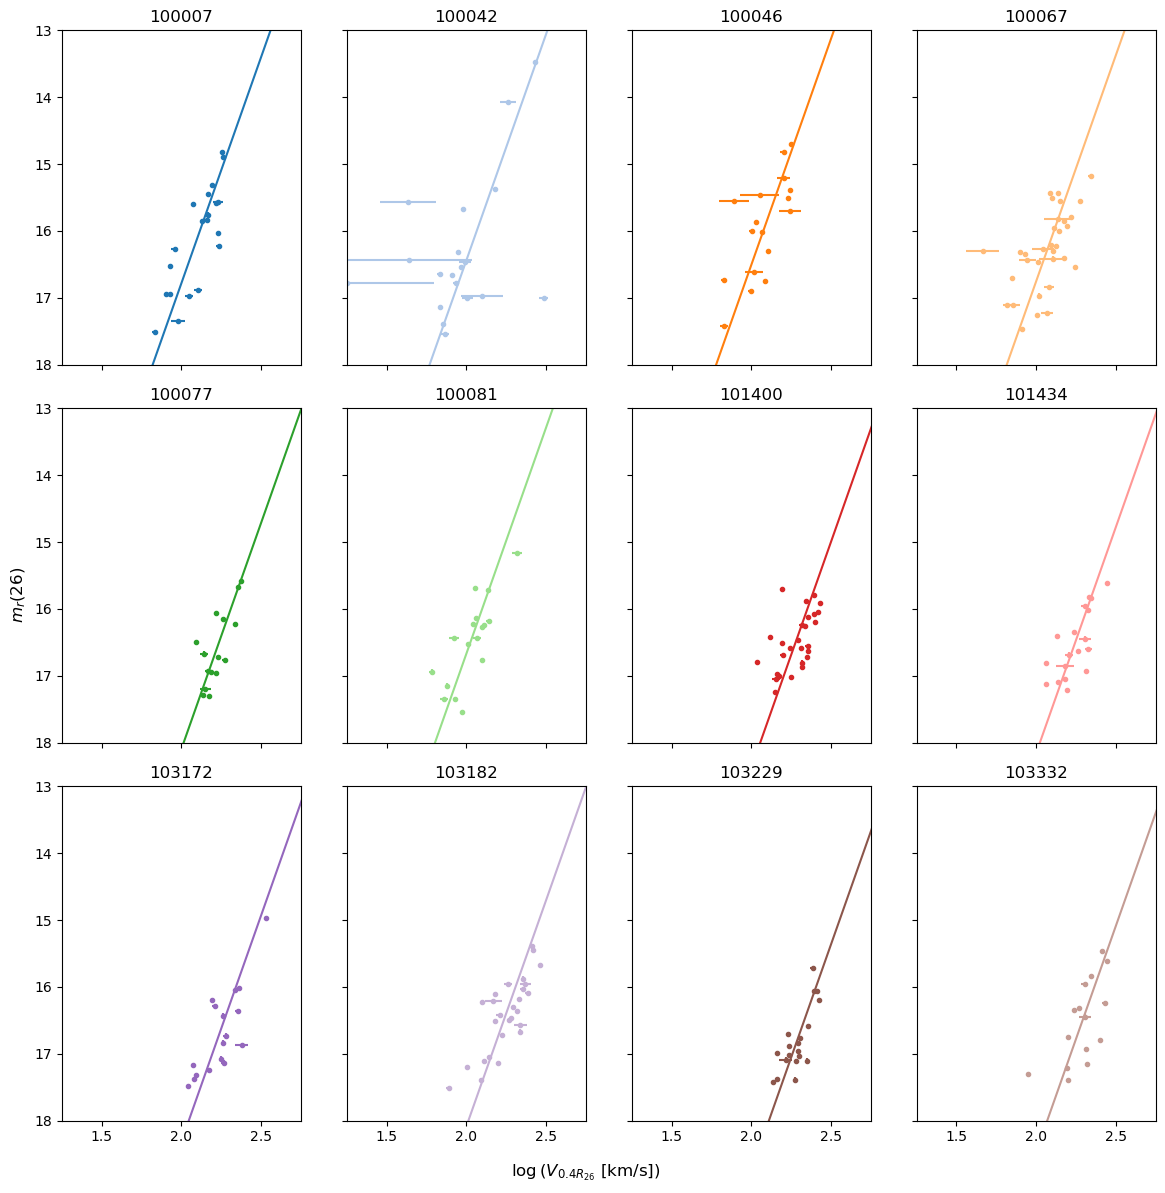

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(12,12), tight_layout=True)

color = iter(plt.get_cmap('tab20').colors)
for i in range(m):
    c = next(color)
    
    row = int(i/4)
    col = i%4
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.75], ylim=[18, 13], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r (26)$');

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [29]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

47.21409819614907 km/s


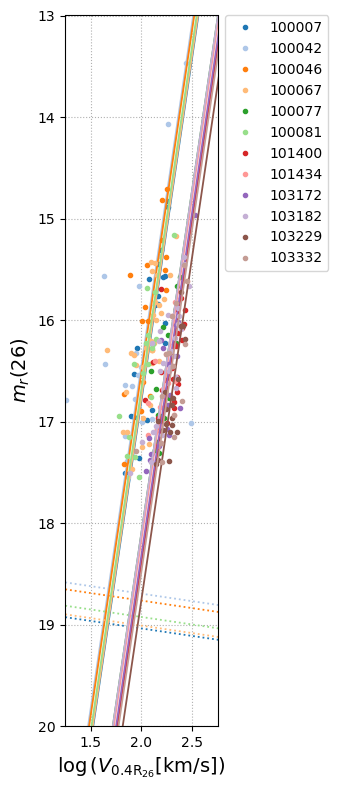

In [78]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.75)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm cluster \perp}
\end{equation}

In [79]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
